# LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import imageio
from sklearn.model_selection import GridSearchCV, cross_val_score
from skorch import NeuralNetClassifier, NeuralNetRegressor
import seaborn as sns
from sklearn.metrics import confusion_matrix
import optuna
from optuna.samplers import TPESampler, RandomSampler

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

from torchvision import transforms
from torchsummary import summary
from torchbearer.cv_utils import DatasetValidationSplitter
from torchbearer import Trial

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


# REGRESSION TASK

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

The dataset is composed by 100 points taken from an unknown function affected by some noise. Also some test points are provided in order to test the goodness of the fit.
The command `read_csv` is used to read the .csv file from the `pandas` library.

In [3]:
#path where the files are
root='regression_dataset/'

train_df=pd.read_csv(root+"train_data.csv")
test_df=pd.read_csv(root+"test_data.csv")

print(f"Lenght of training set: {len(train_df)}")
print(f"Lenght of test set: {len(test_df)}")

Lenght of training set: 100
Lenght of test set: 100


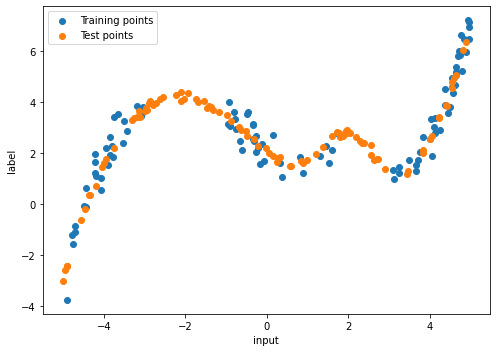

In [4]:
fig = plt.figure(figsize=(7,5))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.tight_layout()

### Dataset class

A customized dataset class is built in order to manipulate the data and prepare them fro the training. Initially the `loadtxt` command from numpy is used in order to import the whole dataset, and it is automatically divided in input and target  by the function.

In [5]:
class RegrDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform

        self.data=np.loadtxt(csv_file, skiprows=True, delimiter=",")
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

### Transformations

The only transformation applied to the dataset is the one which transforms each point in a couple of float torch Tensors of dimension 1.

In [6]:
composed_transform = transforms.Compose([ToTensor()])

train_regr=RegrDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_set=RegrDataset('regression_dataset/test_data.csv', transform=composed_transform)

## Network

Functions for the customized layers initialization, which can play a role in the speed of the convergense of the network.

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def weights_init_xavier_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

The Module calss to build the NN for the regression task. It is composed by some fixed Dense layers at the begging and at the end, while the central part is composed by a `Sequential` module which can vary in depth and number of units with the input parameters of the module. This helps to get an idea about how the depth of the NN influence the performances.
For the regularization, some `Dropout` layers are used, with probability to suppress a given units that can vary with the Module *dropout* parameter.
For the activations, the `Sigmoid` function is used, but in the hyperparametr optimization other function will be tested, as the `ReLU` and `Tanh`.

In [8]:
Ni,No=1,1 #dimension of input and output respectly

class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=30,
            nonlin=nn.Sigmoid(),
            depth=3,
            dropout=0.
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.depth = depth
        self.dropout = dropout

        self.dense0 = nn.Linear(1, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(p=dropout)
        
        lyrs=[]
        for d in range(self.depth-1):
            lyrs.append(nn.Linear(num_units, num_units))
            lyrs.append(self.dropout)
            lyrs.append(self.nonlin)
        self.deep = nn.Sequential(*lyrs)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.deep(X)
        X = self.output(X)
        return X

The network for the regression is then initialized, moved to the GPU and finally its structure and output dimension are displayed thenks to the `summary` function from the `torchsummary` library.
As it is possiible too see, the total number of paramters is in the order of some thousands, so the network will be quite fast and easy to train as will be shown successively.

In [9]:
regmod = RegressorModule()
regmod.to(device)

summary(regmod, (1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 30]              60
           Sigmoid-2                [-1, 1, 30]               0
           Sigmoid-3                [-1, 1, 30]               0
            Linear-4                [-1, 1, 30]             930
           Dropout-5                [-1, 1, 30]               0
           Dropout-6                [-1, 1, 30]               0
           Sigmoid-7                [-1, 1, 30]               0
           Sigmoid-8                [-1, 1, 30]               0
            Linear-9                [-1, 1, 30]             930
          Dropout-10                [-1, 1, 30]               0
          Dropout-11                [-1, 1, 30]               0
          Sigmoid-12                [-1, 1, 30]               0
          Sigmoid-13                [-1, 1, 30]               0
           Linear-14                 [-

A function for the Dataloder construction is implemented, in order to have the possibility to easily change the train-validation dataset proportions and the batch size.
The ratio between train and validation test is considered quite important in ordder to have a good evaluation of the goodness of the fit, because, due to the lack of samples, the problem of the overfitting is especially dangerous in this case.

In [10]:
def DataloadersBuilding(train_d, test_d, split_size, batch_size):

    train_dim=int(len(train_d)*split_size)
    val_dim=int(len(train_d)-train_dim)

    train_set, val_set = random_split(train_d, [train_dim,val_dim])

    train_dataloader = DataLoader(train_set, batch_size=int(batch_size), shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_set,  batch_size=len(val_set), shuffle=False, num_workers=0)
    test_dataloader  = DataLoader(test_d,  batch_size=len(test_set), shuffle=False, num_workers=0)

    return train_dataloader, val_dataloader, test_dataloader

train_dataloader_regr, val_dataloader_regr, test_dataloader_regr = DataloadersBuilding(train_regr, test_set, 0.8, 20)

print("Dimenison of training dataset: %d" %(len(train_dataloader_regr.dataset)))
print("Dimenison of validation dataset: %d" %(len(val_dataloader_regr.dataset)))

Dimenison of training dataset: 80
Dimenison of validation dataset: 20


Here some functions for the training and the testing of the network for 1 epoch are defined. The main difference is that in the first one the gradient of the NN is computed, and thanks to the backpropation algorithm (`backward()` function), the weights are updated with respect to the loss compued between the output of the network and the target. In the second one this section is not present, because we only need to test the network performance, not to update it.

In [11]:
def train_loop(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss=[]
    for sample_batched in dataloader:
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = model(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        model.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    return np.mean(train_loss)

In [12]:
def val_loop(model, dataloader, loss_fn):
    model.eval()
    val_loss=[]
    with torch.no_grad():
        for sample_batched in dataloader:
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            # Forward pass
            out = model(x_batch)
            # Compute loss
            loss = loss_fn(out, label_batch)
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

    # Save average train loss
    return np.mean(val_loss)

## Results

In [13]:
def output_eval(mod):
    # Input vector
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

    # Network output
    mod.eval()

    with torch.no_grad(): # turn off gradients computation
        y_vec = mod(x_vec)

    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()
    
    return x_vec, y_vec

Function that plots the graph produced by the ouputs of the network, both for its final state and the iteration in which the validation loss reached the minimum (the *checkpoint* network in the code), and the training and loss trend with the epochs.

In [14]:
def standard_plots(model, check_path, train_loss_log, val_loss_log):
    
    check_net=RegressorModule(num_units=model.num_units, nonlin=model.nonlin, depth=model.depth)
    check_net.load_state_dict(torch.load(check_path, map_location=device))

    x_vec, y_vec = output_eval(model.cpu())
    x_chk, y_chk = output_eval(check_net.cpu())

    ord_vec=np.array([train_df.input, train_df.label]).T
    ord_vec=ord_vec[ord_vec[:,0].argsort()]
    _, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(17,7))
    
    #Plot outputs
    ax1.plot(x_vec, y_vec, label='Network output', color="navy", lw=3)
    ax1.plot(x_chk, y_chk, label='Checkpoint output', color="gold", lw=3)
    ax1.scatter(train_df.input, train_df.label, label='Training points',color="r")
    ax1.scatter(test_df.input, test_df.label, label='Test points',color="g")
    ax1.grid()
    ax1.legend()
    plt.tight_layout()

    # Plot loss
    ax2.semilogy(train_loss_log, label="Train loss")
    ax2.semilogy(val_loss_log, label="Validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

Here the function for the whole training of the network is defined. The choice to write a single function arisis from the fact that in this way the change of hyperparameters is much easier to handle in the optimization phase.

In [15]:
def regr_training(n_epochs=2000, 
                  tr_te_split=0.8, 
                  batch_size=20, 
                  num_units=10, 
                  depth=3, 
                  dropout=0,
                  nonlin="sigmoid",
                  mod_loss=nn.MSELoss(), 
                  mod_opt_name="Adam",
                  weights_init=None,
                  lr=1e-3, 
                  w_d=1e-5,
                  momentum=0.9, 
                  gif=False,
                  Dat_Build=True,
                  train_dtl_inp=train_dataloader_regr,
                  val_dtl_inp=val_dataloader_regr):
    
    if Dat_Build:
        train_dtl, val_dtl, test_dtl = DataloadersBuilding(train_regr, test_set, tr_te_split, batch_size)
    else:
        train_dtl, val_dtl = train_dtl_inp, val_dtl_inp

    train_loss_log, val_loss_log = [], []
    best_valloss = 1e100

    #activation choice
    if nonlin=="Sigmoid" or nonlin=="sigmoid":
        activ=nn.Sigmoid()
    elif nonlin=="ReLU" or nonlin=="relu":
        activ=nn.ReLU()
    elif nonlin=="Tanh" or nonlin=="tanh":
        activ=nn.Tanh()

    model = RegressorModule(num_units=num_units, depth=depth, dropout=dropout, nonlin=activ)
    if weights_init!=None:
        model.apply(weights_init)
    
    model.to(device)

    #optimizer choice
    if mod_opt_name=="Adam" or mod_opt_name=="adam":
        mod_opt = optim.Adam(model.parameters(),lr=lr,weight_decay=w_d)
    elif mod_opt_name=="SGD" or mod_opt_name=="sgd":
        mod_opt = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    else:
        mod_opt = optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-5)


    for epoch in tqdm(range(n_epochs)):
        trainloss = train_loop(model, train_dtl, mod_loss, mod_opt)
        train_loss_log.append(trainloss)
        valloss = val_loop(model, val_dtl, mod_loss)
        val_loss_log.append(valloss)
        if gif: #save the model parameters each 10 epochs
            if epoch%50==0:
                torch.save(model.state_dict(), f"modforim/version_epoch{int(epoch/50)}.h5")

        if valloss<best_valloss:
            best_valloss=valloss
            torch.save(model.state_dict(), "best_version_provv.h5")
            best_epoch=epoch
    
    if gif: 
        #with the saved model draw the graphs and save them in modforim folder
        plt.close()
        for i in range(int(n_epochs/50)):
            gif_net=RegressorModule(num_units=model.num_units, nonlin=model.nonlin, depth=model.depth)
            gif_net.load_state_dict(torch.load(f'modforim/version_epoch{i}.h5', map_location=device))
            x_chk, y_chk = output_eval(gif_net.cpu())
            
            plt.scatter(train_df.input, train_df.label, label='Training points',color="r", s=5)
            plt.scatter(test_df.input, test_df.label, label='Test points',color="g", s=5)
            plt.plot(x_chk, y_chk, color="navy", lw=2)
            plt.title(f"Epoch nr {i*50}")
            plt.ylim([-4,8])
            plt.savefig(f'modforim/im{i}.png')
            plt.close()

        #create the gif
        with imageio.get_writer('mygif.gif', mode='I') as writer:
            for i in range(int(n_epochs/50)):
                image = imageio.imread(f'modforim/im{i}.png')
                writer.append_data(image)
            
    return train_loss_log, val_loss_log, model

In [16]:
regr_loss = nn.MSELoss()

In [17]:
np.random.seed(0)
torch.manual_seed(2000)

train_loss_regr, val_loss_regr, reg_net = regr_training(n_epochs=3000, 
                                                        tr_te_split=0.9, 
                                                        batch_size=20, 
                                                        num_units=10, 
                                                        depth=3, 
                                                        dropout=0,
                                                        nonlin="sigmoid",
                                                        weights_init=None,
                                                        mod_loss=regr_loss, 
                                                        mod_opt_name="Adam", 
                                                        lr=0.01,
                                                        w_d=1e-5,
                                                        gif=True
                                                        )

100%|██████████| 3000/3000 [00:21<00:00, 137.01it/s]


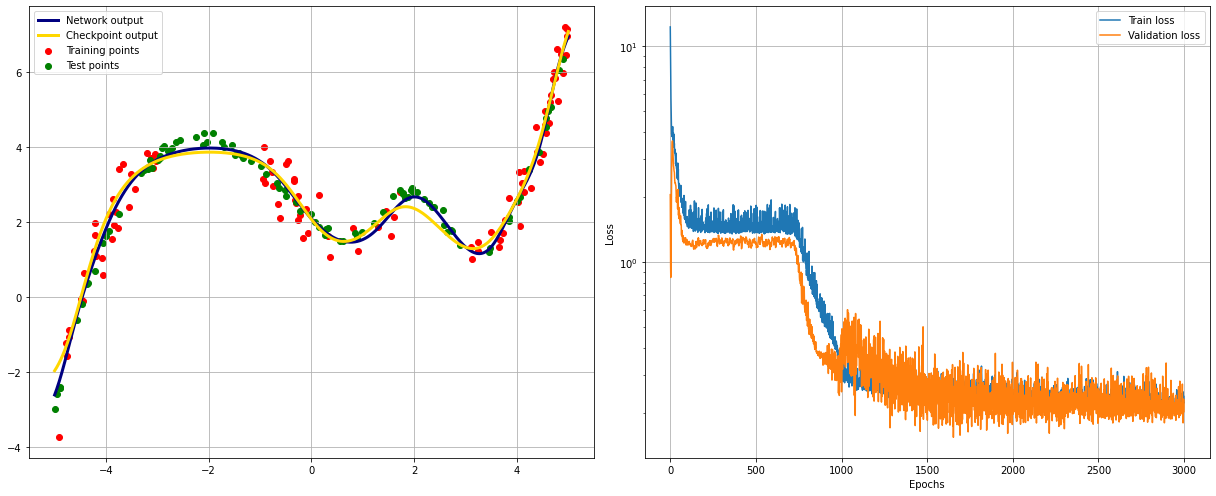

In [18]:
standard_plots(reg_net, 'best_version_provv.h5' ,train_loss_regr, val_loss_regr)

In [19]:
print("Loss on the test set: %.4f" %(val_loop(reg_net.to(device), test_dataloader_regr,nn.MSELoss())))

Loss on the test set: 0.0327


By looking at the loss it's possible to see some steps, which, by analyzing the GIF, is possible to connect to the moments in which the network "understands" the presence of one of the two slopes. In fact usually in the early epoch there is the step for the slope with maximum in -2, the bigger one, while after some other thousands of epochs, another step occurs for the detection of the smaller slope with maximum in 2.

The hyperparameters used in this case were chosen after observing many attempt's results and by evaluating the goodness of the fit also by looking by eye the output with respect to the samples.

### Weights Histograms

In the following section the weights and biases values for some layers of the network are plotted.

In [20]:
# First hidden layer
h1_w = reg_net.dense0.weight.data.cpu().numpy()
h1_b = reg_net.dense0.bias.data.cpu().numpy()

# Second hidden layer
h2_w = reg_net.deep[0].weight.data.cpu().numpy()
h2_b = reg_net.deep[0].bias.data.cpu().numpy()

# Output layer
out_w = reg_net.deep[3].weight.data.cpu().numpy()
out_b = reg_net.deep[3].bias.data.cpu().numpy()

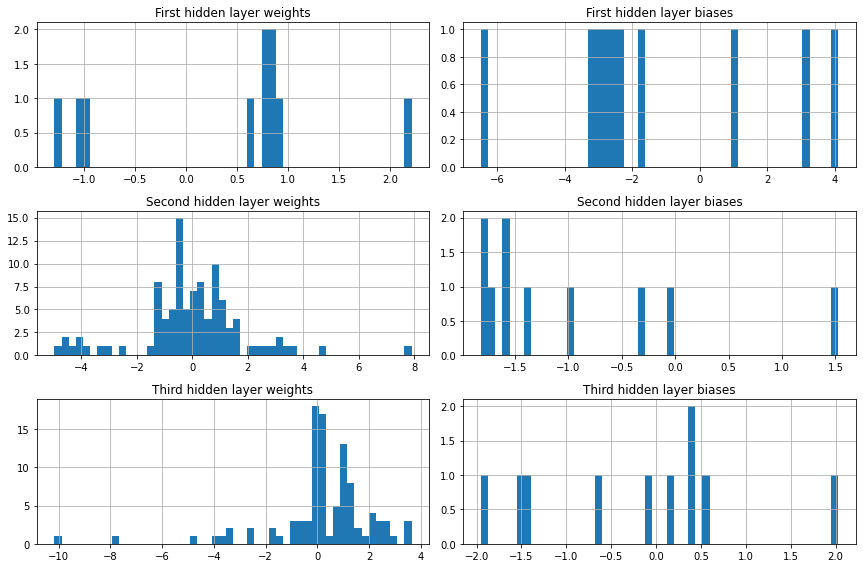

In [21]:
# Weights histogram
fig, axs = plt.subplots(3, 2, figsize=(12,8))
axs[0,0].hist(h1_w.flatten(), 50)
axs[0,0].set_title('First hidden layer weights')
axs[0,1].hist(h1_b.flatten(), 50)
axs[0,1].set_title('First hidden layer biases')

axs[1,0].hist(h2_w.flatten(), 50)
axs[1,0].set_title('Second hidden layer weights')
axs[1,1].hist(h2_b.flatten(), 50)
axs[1,1].set_title('Second hidden layer biases')

axs[2,0].hist(out_w.flatten(), 50)
axs[2,0].set_title('Third hidden layer weights')
axs[2,1].hist(out_b.flatten(), 50)
axs[2,1].set_title('Third hidden layer biases')


[ax.grid() for ax in axs.flatten()]
plt.tight_layout()
plt.show()

### Activations

Thanks to the `register_forward_hook` function, it is possible to obtain the activation of the network for specific inputs. In the stem graphs some examples are shown.

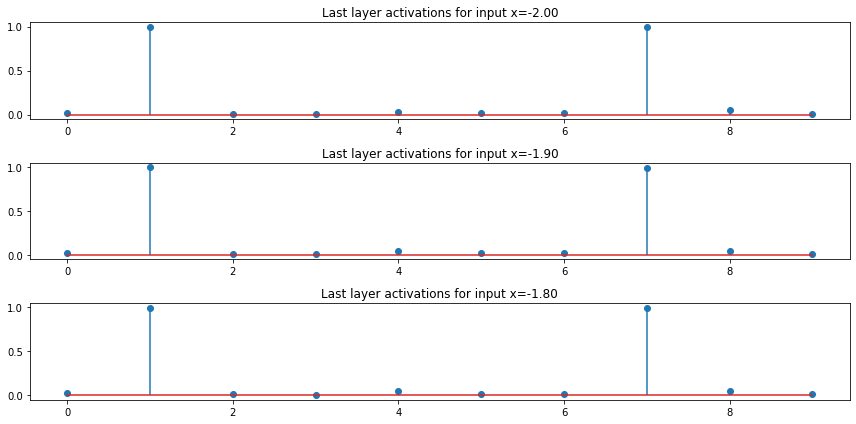

In [22]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)
    return activation

### Register hook  
hook_handle = reg_net.dense0.register_forward_hook(get_activation)

### Analyze activations
reg_net.to(device)
reg_net.eval()
with torch.no_grad():
    x1 = torch.tensor([-2]).float().to(device)
    y1 = reg_net(x1)
    z1 = activation
    x2 = torch.tensor([-1.9]).float().to(device)
    y2 = reg_net(x2)
    z2 = activation
    x3 = torch.tensor([-1.8]).float().to(device)
    y3 = reg_net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

Generate GIF to understand the behaviour of the activation with respect to the value of the input point.

In [23]:
### Register hook  
hook_handle = reg_net.dense1.register_forward_hook(get_activation)

### Analyze activations
reg_net.to(device)
reg_net.eval()
z_vec=[]
with torch.no_grad():
    for x in np.linspace(-5,5,200):
        x1 = torch.tensor([x]).float().to(device)
        y1 = reg_net(x1)
        z_vec.append(activation.cpu().numpy())


### Remove hook
hook_handle.remove()

### Plot activations
plt.close()
for i in range(200):
    plt.stem(z_vec[i], use_line_collection=True)
    plt.ylim(-0.05,1.05)
    plt.title(np.linspace(-5,5,200)[i])
    plt.savefig(f'modforim/im_stem{i}.png')

    plt.close()

#create the gif
with imageio.get_writer('mygif_stem.gif', mode='I') as writer:
    for i in range(200):
        image = imageio.imread(f'modforim/im_stem{i}.png')
        writer.append_data(image)


### Receptive Fields

It is now possible to apply the procedure of the above section to the entire range of outr dataset. This provides us with the receptive fields of the NN with respect tot the different layers, i.e. the region if the input space for which a specific neuron gets activated.

In [24]:
def receptiveFields(hook, title):
    rec_field=[]
    hook_handle = hook
    reg_net.eval()

    for i, p in enumerate(np.linspace(-5,5,50)):
        with torch.no_grad():
            x = torch.tensor([p]).float().to(device)
            y = reg_net(x)
            z = activation
            rec_field.append(z.detach().cpu().numpy())

    hook_handle.remove()
    __,ax = plt.subplots(1,1, figsize=(15,2))
    sns.heatmap(torch.Tensor(rec_field).T, ax=ax, cmap="magma")
    ax.set_title("Receptive field "+title, fontweight="bold")

    return rec_field

In [25]:
print(reg_net)

RegressorModule(
  (nonlin): Sigmoid()
  (dense0): Linear(in_features=1, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (deep): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): Sigmoid()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): Sigmoid()
  )
  (dense1): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


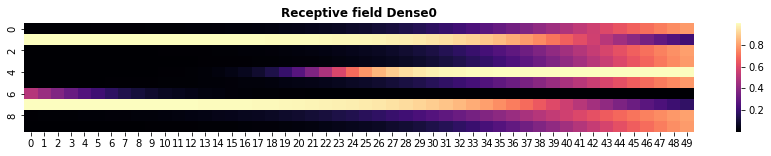

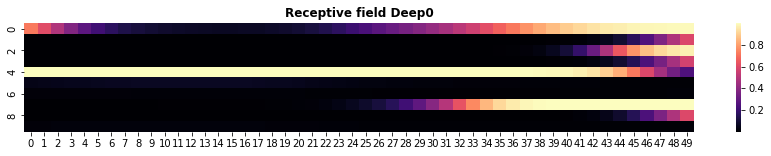

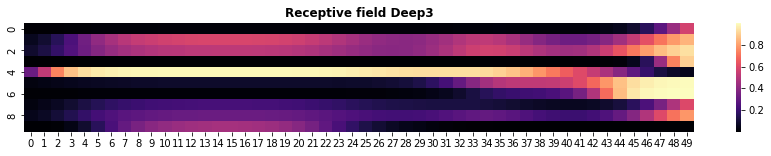

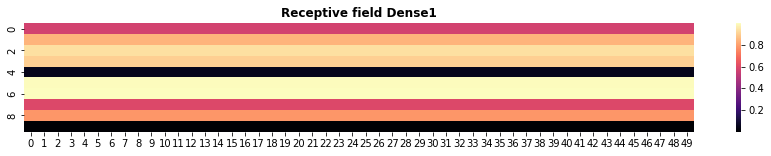

In [26]:
dense0_rf=receptiveFields(reg_net.dense0.register_forward_hook(get_activation), "Dense0")
deep0_rf=receptiveFields(reg_net.deep[0].register_forward_hook(get_activation), "Deep0")
deep3_rf=receptiveFields(reg_net.deep[3].register_forward_hook(get_activation), "Deep3")
dense1_rf=receptiveFields(reg_net.dense1.register_forward_hook(get_activation), "Dense1")


## Grid-Search (SKORCH)

In order to perform a grid search over the hyperparameters of the model, it is used the `Skorch` library, which allows to wrap in the sklearn enviroment a pytorch module. This allows to use all the functinoalities of `sklearn`, as the `GridsearchCV` and `KFold` cross validation in an easy way.

In [27]:
#some modification on the dataset in order to use it in the skorch enviroment
X_regr = train_regr.data[:,0].astype(np.float32).reshape(-1,1)
y_regr = train_regr.data[:,1].astype(np.float32)
y_regr = y_regr.reshape(-1, 1)

X_regr.shape, y_regr.shape, y_regr.min(), y_regr.max()

((100, 1), (100, 1), -3.7429695, 7.1993046)

Skorch allows to insert all the parameters of the model in as parameters of the NeuralNet functions (one for regression and one for classification).

In [28]:
net_regr = NeuralNetRegressor(
    RegressorModule,
    module__depth=2,
    module__num_units=30,
    max_epochs=2000,
    
    optimizer=optim.Adam ,
    lr=0.01,
    optimizer__weight_decay=1e-4,
    
    criterion=nn.MSELoss,
    batch_size=40,
    device='cuda',  # uncomment this to train with CUDA
    verbose=0
)

The dataset is automatically and randomically splitted into trainig and validation set, with a default ratio of 0.2.

In [29]:
net_regr.fit(X_regr, y_regr)

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (nonlin): Sigmoid()
    (dense0): Linear(in_features=1, out_features=30, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (deep): Sequential(
      (0): Linear(in_features=30, out_features=30, bias=True)
      (1): Dropout(p=0.0, inplace=False)
      (2): Sigmoid()
    )
    (dense1): Linear(in_features=30, out_features=30, bias=True)
    (output): Linear(in_features=30, out_features=1, bias=True)
  ),
)

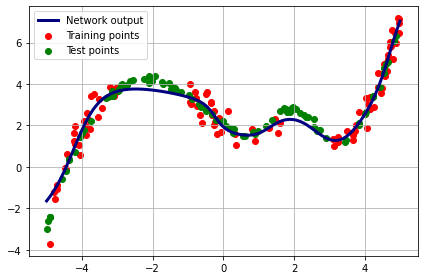

In [30]:
x_ver=np.linspace(-5,5,100).astype(np.float32).reshape(-1,1)

#Plot outputs
plt.plot(x_ver, net_regr.predict(x_ver), label='Network output', color="navy", lw=3)
plt.scatter(train_df.input, train_df.label, label='Training points',color="r")
plt.scatter(test_df.input, test_df.label, label='Test points',color="g")
plt.grid()
plt.legend()
plt.tight_layout()

Now the `GrisSearchCV` function is used. It allows to run the model over all the possible combination of the values of hyperparameters given in input, and compare the results obtained by evaluating a scoring function (in this case the accuracy), with the Cross validation procedure. Only a few parameters are considered, because the fuction gets exponentially heavy as the number of parameters increase.

In [31]:
params = {
    'module__num_units': [10, 20, 30],
    'module__depth': [2,3,4]
}

gs = GridSearchCV(net_regr, params, cv=3, scoring='neg_root_mean_squared_error')

gs.fit(X_regr, y_regr)
print(gs.best_score_, gs.best_params_)

-1.7161838610967 {'module__depth': 3, 'module__num_units': 10}


## Random Search (OPTUNA)

Another way to perform the hyperparameter optimization is by using the `Optuna` library, which implements a function that progressively chooses the different hyperparameters values within each corresponding range, by exploit a Bayesian research act to the minimization of the loss.

In [33]:
np.random.seed(0)
torch.manual_seed(10)

def objective(trial):

    # We optimize the number of hidden units in each layer.
    hyperparameters = [
        trial.suggest_float("tr_te_split", 0.5,0.9),
        trial.suggest_int("batch_size", 10, 50),
        trial.suggest_int("n_units", 10, 50, log=True),
        trial.suggest_int("depth", 2, 6),
        trial.suggest_float("droput", 0, 0.3),
        trial.suggest_categorical("activation", ["sigmoid", "relu", "tanh"]),
        trial.suggest_categorical("weights_init", [None, "weights_init_normal", "weights_init_xavier_normal"]),
        trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        trial.suggest_float("lr", 1e-3, 1e-1, log=True),
        trial.suggest_float("w_d", 1e-6, 1e-3, log=True)
    ]

    if hyperparameters[6]=="weights_init_normal":
        hyperparameters[6]=weights_init_normal
    elif hyperparameters[6]=="weights_init_xavier_normal":
        hyperparameters[6]=weights_init_xavier_normal

    train_loss_regr, val_loss_regr, reg_net = regr_training(n_epochs=3000, 
                                                            tr_te_split=hyperparameters[0], 
                                                            batch_size=hyperparameters[1], 
                                                            num_units=hyperparameters[2], 
                                                            depth=hyperparameters[3], 
                                                            dropout=hyperparameters[4],
                                                            nonlin=hyperparameters[5],
                                                            weights_init=hyperparameters[6],
                                                            mod_loss=regr_loss, 
                                                            mod_opt_name=hyperparameters[7], 
                                                            lr=hyperparameters[8],
                                                            w_d=hyperparameters[9])


    return val_loss_regr[-1]

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler = TPESampler(seed=10)
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=40, timeout=10000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Validation loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-11 08:24:22,431] A new study created in memory with name: myfirstoptimizationstudy
100%|██████████| 3000/3000 [00:41<00:00, 72.51it/s]
[I 2022-01-11 08:25:03,812] Trial 0 finished with value: 0.9571823477745056 and parameters: {'tr_te_split': 0.8085282573066984, 'batch_size': 10, 'n_units': 27, 'depth': 5, 'droput': 0.14955210369077712, 'activation': 'tanh', 'weights_init': 'weights_init_xavier_normal', 'optimizer': 'Adam', 'lr': 0.010577536357318949, 'w_d': 0.0002740708741343236}. Best is trial 0 with value: 0.9571823477745056.
100%|██████████| 3000/3000 [00:19<00:00, 154.42it/s]
[I 2022-01-11 08:25:23,244] Trial 1 finished with value: 1.4135193824768066 and parameters: {'tr_te_split': 0.7450104267317552, 'batch_size': 39, 'n_units': 15, 'depth': 6, 'droput': 0.21437273501930718, 'activation': 'sigmoid', 'weights_init': None, 'optimizer': 'Adam', 'lr': 0.019989151697755378, 'w_d': 6.355019100735403e-05}. Best is trial 0 with value: 0.9571823477745056.
100%|██████████| 3000/

Number of finished trials: 40
Best trial:
  Validation loss: 0.20793214440345764
  Params: 
    tr_te_split: 0.602096681757778
    batch_size: 42
    n_units: 15
    depth: 2
    droput: 0.05259048188490828
    activation: relu
    weights_init: None
    optimizer: Adam
    lr: 0.006185416394122796
    w_d: 2.31316795451909e-05


The results of the hyperparameters optimization are quite unexpected, but plausible by reasoning about the structure of the problem. The `relu` activation function produce a polyline, fact witch is not desirable as final result of the task, but the network, only by looking at the validation loss, doesn't make any distinction over the smoothness of the output, so even this kind of trend is good as long as it produces good results. Then the other parameters, as the learning rate and the weight decay, change accordingly. In particular the learning rate can be smaller with respect to the case in which a `sigmoid` or `tanh` activation are used, while the weight decay value is higher.
Even the number of units and the depth of the network increase is we are satisfied with a polyline as output, because, by enlarging the number of units, even the vertex of the polyline increase, so the generalization capabilities increase.

100%|██████████| 3000/3000 [00:09<00:00, 318.86it/s]


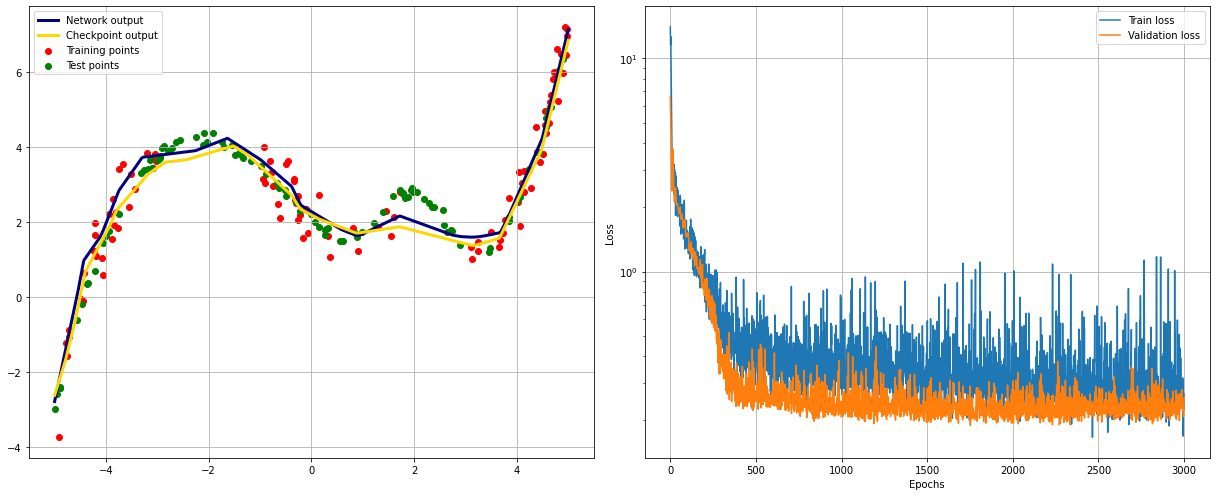

In [34]:
np.random.seed(0)
torch.manual_seed(2)

hyp_opt_val = list(trial.params.values())
if hyp_opt_val[6]=="weights_init_normal":
    hyp_opt_val[6]=weights_init_normal
elif hyp_opt_val[6]=="weights_init_xavier_normal":
    hyp_opt_val[6]=weights_init_xavier_normal


train_loss_regr, val_loss_regr, reg_net_opt = regr_training(n_epochs=3000, 
                                                        tr_te_split=hyp_opt_val[0], 
                                                        batch_size=hyp_opt_val[1], 
                                                        num_units=hyp_opt_val[2], 
                                                        depth=hyp_opt_val[3], 
                                                        dropout=hyp_opt_val[4],
                                                        nonlin=hyp_opt_val[5],
                                                        weights_init=hyp_opt_val[6],
                                                        mod_loss=regr_loss, 
                                                        mod_opt_name=hyp_opt_val[7], 
                                                        lr=hyp_opt_val[8],
                                                        w_d=hyp_opt_val[9]
                                                        )

standard_plots(reg_net_opt, 'best_version_provv.h5' ,train_loss_regr, val_loss_regr)

In [35]:
print("Loss on the test set: %.4f" %(val_loop(reg_net_opt.to(device), test_dataloader_regr,nn.MSELoss())))

Loss on the test set: 0.1496


A problem arises. The shortage of data has as a consequence the difficulty in evaluating the goodness of the regression results. A good final score of a trial could be due to a lucky split of training-validation set. In order to reduce the plausibility of such a scenario, it's good practice to use the KFold cross validation procedure. In this case the number of folds is chosen equal to 5, so the training-validation ratio will be 0.8.

In [36]:
np.random.seed(0)
torch.manual_seed(10)

def objective(trial):

    # We optimize the number of hidden units in each layer.
    hyperparameters = [
        trial.suggest_int("n_units", 10, 50, log=True),
        trial.suggest_int("depth", 2, 5),
        trial.suggest_float("droput", 0, 0.3),
        trial.suggest_categorical("activation", ["sigmoid","relu","tanh"]),
        trial.suggest_categorical("weights_init", [None, "weights_init_normal", "weights_init_xavier_normal"]),
        trial.suggest_categorical("optimizer", ["Adam", "SGD"]),
        trial.suggest_float("lr", 1e-3, 1e-1, log=True),
        trial.suggest_float("w_d", 1e-6, 1e-2, log=True)
    ]

    if hyperparameters[4]=="weights_init_normal":
        hyperparameters[4]=weights_init_normal
    elif hyperparameters[4]=="weights_init_xavier_normal":
        hyperparameters[4]=weights_init_xavier_normal

    kf=KFold(5, shuffle=True)
    val_kf=[]
    n_it=1
    for train_index, test_index in kf.split(train_regr):

        train_subsamp = SubsetRandomSampler(train_index)
        test_subsamp = SubsetRandomSampler(test_index)
        trainloader_kf = DataLoader(
                        train_regr, 
                        batch_size=128, sampler=train_subsamp,pin_memory=True)
        testloader_kf = DataLoader(
                        train_regr,
                        batch_size=128, sampler=test_subsamp, pin_memory=True)
        #print("Training on permutation nr. %d" %(n_it))
        train_loss_kf, val_loss_kf, reg_net_kf = regr_training(n_epochs=2000, 
                                                                num_units=hyperparameters[0], 
                                                                depth=hyperparameters[1], 
                                                                dropout=hyperparameters[2],
                                                                nonlin=hyperparameters[3],
                                                                weights_init=hyperparameters[4],
                                                                mod_loss=regr_loss, 
                                                                mod_opt_name=hyperparameters[5], 
                                                                lr=hyperparameters[6],
                                                                w_d=hyperparameters[7],
                                                                Dat_Build=False,
                                                                train_dtl_inp=trainloader_kf,
                                                                val_dtl_inp=testloader_kf)
        val_kf.append(np.mean(val_loss_kf[-50:-1]))
        n_it+=1
    return np.mean(val_kf)

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

sampler = TPESampler(seed=10)
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=40, timeout=15000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Validation loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    

[I 2022-01-11 08:35:54,828] A new study created in memory with name: myfirstoptimizationstudy
100%|██████████| 2000/2000 [00:04<00:00, 462.65it/s]
[I 2022-01-11 08:36:16,617] Trial 0 finished with value: 1.897121787071228 and parameters: {'n_units': 34, 'depth': 2, 'droput': 0.1900944704778826, 'activation': 'sigmoid', 'weights_init': 'weights_init_normal', 'optimizer': 'SGD', 'lr': 0.08068386469121067, 'w_d': 1.037034167132713e-06}. Best is trial 0 with value: 1.897121787071228.
100%|██████████| 2000/2000 [00:05<00:00, 387.92it/s]
[I 2022-01-11 08:36:42,652] Trial 1 finished with value: 0.5962965488433838 and parameters: {'n_units': 22, 'depth': 5, 'droput': 0.18375782004881644, 'activation': 'tanh', 'weights_init': None, 'optimizer': 'SGD', 'lr': 0.007650086554079969, 'w_d': 5.4457283469779006e-05}. Best is trial 1 with value: 0.5962965488433838.
100%|██████████| 2000/2000 [00:05<00:00, 361.15it/s]
[I 2022-01-11 08:37:10,080] Trial 2 finished with value: 0.8329387903213501 and parame

Number of finished trials: 40
Best trial:
  Validation loss: 0.29380643367767334
  Params: 
    n_units: 12
    depth: 2
    droput: 0.0008217785586903323
    activation: tanh
    weights_init: None
    optimizer: SGD
    lr: 0.0074718345381309436
    w_d: 1.3908623133979945e-05


100%|██████████| 3000/3000 [00:12<00:00, 245.47it/s]


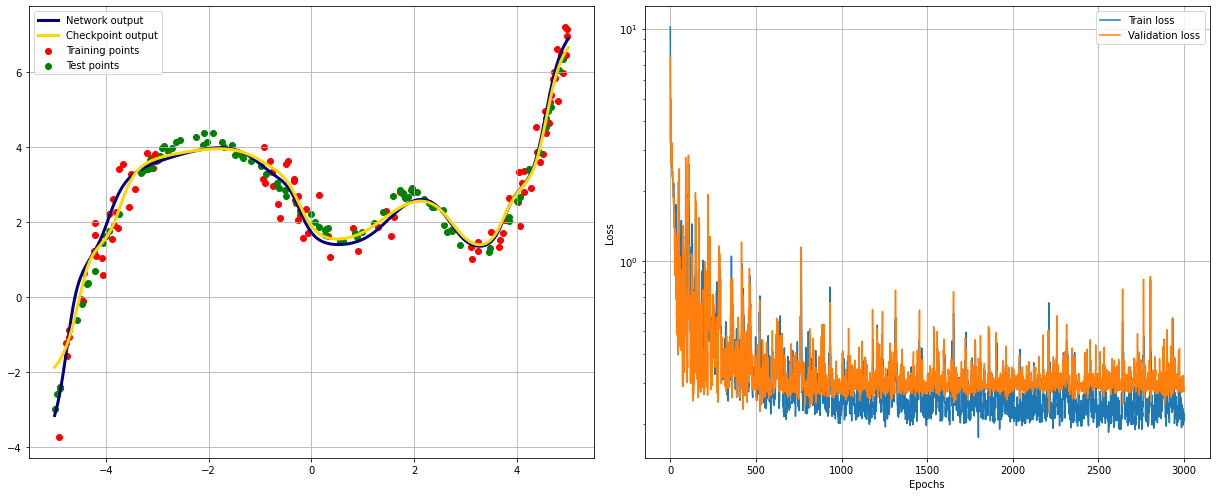

In [37]:
np.random.seed(0)
torch.manual_seed(10)

hyp_opt_val = list(trial.params.values())
if hyp_opt_val[4]=="weights_init_normal":
    hyp_opt_val[4]=weights_init_normal
elif hyp_opt_val[4]=="weights_init_xavier_normal":
    hyp_opt_val[4]=weights_init_xavier_normal


train_loss_regr, val_loss_regr, reg_net_cv = regr_training(n_epochs=3000,  
                                                        num_units=hyp_opt_val[0], 
                                                        depth=hyp_opt_val[1], 
                                                        dropout=hyp_opt_val[2],
                                                        nonlin=hyp_opt_val[3],
                                                        weights_init=hyp_opt_val[4],
                                                        mod_loss=regr_loss, 
                                                        mod_opt_name=hyp_opt_val[5], 
                                                        lr=hyp_opt_val[6],
                                                        w_d=hyp_opt_val[7])

standard_plots(reg_net_cv, 'best_version_provv.h5' ,train_loss_regr, val_loss_regr)

In [38]:
print("Loss on the test set: %.4f" %(val_loop(reg_net_cv.to(device), test_dataloader_regr,nn.MSELoss())))

Loss on the test set: 0.0864


## Random Search (Manual)

But another problem arises: a given combination of hyperparameters that returns a good score could be very distant with respect to more than one parameter from another good combination, which could lead even to better results. E.g the values of the learning rate that produce good results strongly depend on the choice of the activation function, or also, the weight_decay parameter relevance in the problem is correlated to the size of the architecture, i.e. the number of weights. The OPTUNA algorithm tends to focus its search around the good combinations it finds, so it's very that it manages to "jump" to a different and distant one, that would require to guess a completely new combination of the parameters based on the previous results. To avoid this problem also a RANDOM SEARCH algorithm is implemented, in which the hyperparameter combination of a certain trial doesn't depend on the combination of the past ones.

In [39]:
np.random.seed(0)
torch.manual_seed(10)

n_randon_iter = 50
best_params={}
best_it=0
best_score=10e10

for n in range(n_randon_iter):
    n_units = np.random.randint(10,50)
    depth=np.random.randint(2, 5)
    dropout_kf=np.random.uniform(0, 0.3)
    activation=np.random.choice(["sigmoid", "tanh","relu"])
    weights_init=np.random.choice([None, weights_init_normal, weights_init_xavier_normal])
    lr=10**np.random.uniform(-3, -1)
    w_d=10**np.random.uniform(-6, -2)

    print("Trial nr: %d" %(n)), "; "
    print("n_units: %d " %(n_units), "; " 
          "depth: %d "%(depth) ,  "; "
          "dropout: %.4f "%(dropout_kf),  "; "
          "activation:  " + activation, "; "
          "weights_init: "+ str(weights_init), "; "
          "lr: %.5f "%(lr),  "; "
          "w_d: %.6f "%(w_d))

    print(dropout_kf)
    kf=KFold(5, shuffle=True)
    val_kf=[]
    n_it=1
    for train_index, test_index in kf.split(train_regr):

        train_subsamp = SubsetRandomSampler(train_index)
        test_subsamp = SubsetRandomSampler(test_index)
        trainloader_kf = DataLoader(
                        train_regr, 
                        batch_size=128, sampler=train_subsamp,pin_memory=True)
        testloader_kf = DataLoader(
                        train_regr,
                        batch_size=128, sampler=test_subsamp, pin_memory=True)

        train_loss_kf, val_loss_kf, reg_net_kf = regr_training(n_epochs=2000,  
                                                                num_units=n_units, 
                                                                depth=depth, 
                                                                dropout=dropout_kf,
                                                                nonlin=activation,
                                                                weights_init=weights_init,
                                                                mod_loss=regr_loss, 
                                                                mod_opt_name="Adam", 
                                                                lr=lr,
                                                                w_d=w_d,
                                                                Dat_Build=False,
                                                                train_dtl_inp=trainloader_kf,
                                                                val_dtl_inp=testloader_kf)
        val_kf.append(np.mean(val_loss_kf[-50:-1]))
        n_it+=1

    curr_score = np.mean(val_kf)
    print("\t Current trial score: %.4f" %(curr_score))
    if curr_score<best_score:
        best_score=curr_score
        best_it=n
        best_params["n_units"]=n_units
        best_params["depth"]=depth
        best_params["dropout"]=dropout_kf
        best_params["activation"]=activation
        best_params["weights_init"]=weights_init
        best_params["lr"]=lr
        best_params["w_d"]=w_d
    print("\t Best iteration: %d;   Best score: %.4f \n"%(best_it, best_score))
    
print("Best parameters: ")
for key,values in zip(best_params.keys(), best_params.values()):
    print(key, values)

Trial nr: 0
n_units: 10  ; depth: 3  ; dropout: 0.1871  ; activation:  relu ; weights_init: None ; lr: 0.00394  ; w_d: 0.000002 
0.1870691090357917


100%|██████████| 2000/2000 [00:06<00:00, 286.39it/s]


	 Current trial score: 0.5321
	 Best iteration: 0;   Best score: 0.5321 

Trial nr: 1
n_units: 49  ; depth: 3  ; dropout: 0.2218  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00368  ; w_d: 0.000003 
0.2217790738194905


100%|██████████| 2000/2000 [00:05<00:00, 340.45it/s]


	 Current trial score: 0.4581
	 Best iteration: 1;   Best score: 0.4581 

Trial nr: 2
n_units: 15  ; depth: 2  ; dropout: 0.0299  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00868  ; w_d: 0.002315 
0.029870726733243324


100%|██████████| 2000/2000 [00:05<00:00, 357.81it/s]


	 Current trial score: 0.3720
	 Best iteration: 2;   Best score: 0.3720 

Trial nr: 3
n_units: 13  ; depth: 2  ; dropout: 0.1937  ; activation:  tanh ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.01811  ; w_d: 0.003095 
0.19373537955056974


100%|██████████| 2000/2000 [00:05<00:00, 367.97it/s]


	 Current trial score: 0.4834
	 Best iteration: 2;   Best score: 0.3720 

Trial nr: 4
n_units: 29  ; depth: 2  ; dropout: 0.1285  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00634  ; w_d: 0.000003 
0.12846714963492242


100%|██████████| 2000/2000 [00:05<00:00, 353.64it/s]


	 Current trial score: 0.3258
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 5
n_units: 25  ; depth: 2  ; dropout: 0.0561  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.01224  ; w_d: 0.000067 
0.056139267525253424


100%|██████████| 2000/2000 [00:06<00:00, 330.38it/s]


	 Current trial score: 0.3435
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 6
n_units: 18  ; depth: 3  ; dropout: 0.1902  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00989  ; w_d: 0.000051 
0.19017928689537741


100%|██████████| 2000/2000 [00:06<00:00, 292.27it/s]


	 Current trial score: 0.4986
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 7
n_units: 44  ; depth: 4  ; dropout: 0.1045  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.01149  ; w_d: 0.006009 
0.10454279671004912


100%|██████████| 2000/2000 [00:06<00:00, 314.20it/s]


	 Current trial score: 1.0507
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 8
n_units: 37  ; depth: 4  ; dropout: 0.1553  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.03018  ; w_d: 0.003911 
0.15528363003077775


100%|██████████| 2000/2000 [00:07<00:00, 262.15it/s]


	 Current trial score: 0.4607
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 9
n_units: 27  ; depth: 3  ; dropout: 0.2570  ; activation:  tanh ; weights_init: None ; lr: 0.00629  ; w_d: 0.000053 
0.25702657412089447


100%|██████████| 2000/2000 [00:06<00:00, 300.92it/s]


	 Current trial score: 0.7418
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 10
n_units: 26  ; depth: 4  ; dropout: 0.2646  ; activation:  sigmoid ; weights_init: None ; lr: 0.00454  ; w_d: 0.001625 
0.2645689509290497


100%|██████████| 2000/2000 [00:06<00:00, 323.39it/s]


	 Current trial score: 2.0768
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 11
n_units: 47  ; depth: 4  ; dropout: 0.1103  ; activation:  sigmoid ; weights_init: None ; lr: 0.00945  ; w_d: 0.000001 
0.11028785201586698


100%|██████████| 2000/2000 [00:06<00:00, 322.54it/s]


	 Current trial score: 0.4599
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 12
n_units: 28  ; depth: 4  ; dropout: 0.2798  ; activation:  sigmoid ; weights_init: None ; lr: 0.05987  ; w_d: 0.000615 
0.27979965946317037


100%|██████████| 2000/2000 [00:07<00:00, 282.03it/s]


	 Current trial score: 2.1877
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 13
n_units: 17  ; depth: 2  ; dropout: 0.0840  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00466  ; w_d: 0.007591 
0.08403412449175117


100%|██████████| 2000/2000 [00:07<00:00, 255.67it/s]


	 Current trial score: 1.7350
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 14
n_units: 13  ; depth: 3  ; dropout: 0.1880  ; activation:  tanh ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00112  ; w_d: 0.000053 
0.18801194278773145


100%|██████████| 2000/2000 [00:06<00:00, 286.31it/s]


	 Current trial score: 2.5422
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 15
n_units: 48  ; depth: 3  ; dropout: 0.0922  ; activation:  tanh ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.08410  ; w_d: 0.000003 
0.09215188522468803


100%|██████████| 2000/2000 [00:07<00:00, 272.40it/s]


	 Current trial score: 3.4449
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 16
n_units: 22  ; depth: 2  ; dropout: 0.1681  ; activation:  relu ; weights_init: None ; lr: 0.03587  ; w_d: 0.000004 
0.16813517661293406


100%|██████████| 2000/2000 [00:07<00:00, 279.47it/s]


	 Current trial score: 0.5758
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 17
n_units: 37  ; depth: 4  ; dropout: 0.0902  ; activation:  relu ; weights_init: None ; lr: 0.00286  ; w_d: 0.000008 
0.09019534760903004


100%|██████████| 2000/2000 [00:06<00:00, 301.43it/s]


	 Current trial score: 0.3821
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 18
n_units: 14  ; depth: 3  ; dropout: 0.1408  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00157  ; w_d: 0.000003 
0.1407509544750588


100%|██████████| 2000/2000 [00:07<00:00, 277.27it/s]


	 Current trial score: 1.6372
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 19
n_units: 14  ; depth: 4  ; dropout: 0.2805  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.02535  ; w_d: 0.000091 
0.2805481536233477


100%|██████████| 2000/2000 [00:08<00:00, 235.86it/s]


	 Current trial score: 1.9124
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 20
n_units: 46  ; depth: 4  ; dropout: 0.1883  ; activation:  tanh ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.01594  ; w_d: 0.001224 
0.1883150768234941


100%|██████████| 2000/2000 [00:08<00:00, 230.46it/s]


	 Current trial score: 0.5716
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 21
n_units: 38  ; depth: 3  ; dropout: 0.0904  ; activation:  tanh ; weights_init: None ; lr: 0.00711  ; w_d: 0.000449 
0.09040817320017495


100%|██████████| 2000/2000 [00:06<00:00, 314.05it/s]


	 Current trial score: 0.3709
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 22
n_units: 40  ; depth: 4  ; dropout: 0.2086  ; activation:  sigmoid ; weights_init: None ; lr: 0.00215  ; w_d: 0.002540 
0.20860394044185895


100%|██████████| 2000/2000 [00:09<00:00, 214.66it/s]


	 Current trial score: 1.9330
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 23
n_units: 16  ; depth: 3  ; dropout: 0.0714  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.06047  ; w_d: 0.001677 
0.07139176288039059


100%|██████████| 2000/2000 [00:08<00:00, 229.17it/s]


	 Current trial score: 0.7594
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 24
n_units: 16  ; depth: 4  ; dropout: 0.1022  ; activation:  tanh ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.03699  ; w_d: 0.000946 
0.10218139316530558


100%|██████████| 2000/2000 [00:08<00:00, 229.95it/s]


	 Current trial score: 0.4987
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 25
n_units: 16  ; depth: 4  ; dropout: 0.0079  ; activation:  relu ; weights_init: None ; lr: 0.03117  ; w_d: 0.000112 
0.007896400585227458


100%|██████████| 2000/2000 [00:07<00:00, 252.27it/s]


	 Current trial score: 0.3425
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 26
n_units: 24  ; depth: 4  ; dropout: 0.0227  ; activation:  sigmoid ; weights_init: None ; lr: 0.00248  ; w_d: 0.007595 
0.02268320191952532


100%|██████████| 2000/2000 [00:08<00:00, 223.23it/s]


	 Current trial score: 1.5921
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 27
n_units: 41  ; depth: 4  ; dropout: 0.0676  ; activation:  relu ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.01812  ; w_d: 0.000009 
0.0676148755224172


100%|██████████| 2000/2000 [00:08<00:00, 240.99it/s]


	 Current trial score: 0.4180
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 28
n_units: 45  ; depth: 3  ; dropout: 0.0692  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00610  ; w_d: 0.000001 
0.0692321823857684


100%|██████████| 2000/2000 [00:08<00:00, 244.91it/s]


	 Current trial score: 0.3806
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 29
n_units: 11  ; depth: 2  ; dropout: 0.1398  ; activation:  tanh ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00169  ; w_d: 0.000003 
0.1398065231478148


100%|██████████| 2000/2000 [00:05<00:00, 357.98it/s]


	 Current trial score: 2.7833
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 30
n_units: 35  ; depth: 2  ; dropout: 0.1745  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00785  ; w_d: 0.001918 
0.17450395294435853


100%|██████████| 2000/2000 [00:06<00:00, 315.35it/s]


	 Current trial score: 0.5032
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 31
n_units: 17  ; depth: 4  ; dropout: 0.1822  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00794  ; w_d: 0.000008 
0.18218265456994504


100%|██████████| 2000/2000 [00:08<00:00, 234.13it/s]


	 Current trial score: 1.7809
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 32
n_units: 39  ; depth: 2  ; dropout: 0.2431  ; activation:  sigmoid ; weights_init: None ; lr: 0.01250  ; w_d: 0.005650 
0.2430872289208308


100%|██████████| 2000/2000 [00:07<00:00, 276.69it/s]


	 Current trial score: 1.2668
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 33
n_units: 49  ; depth: 2  ; dropout: 0.0707  ; activation:  relu ; weights_init: None ; lr: 0.08133  ; w_d: 0.000011 
0.07067016015149244


100%|██████████| 2000/2000 [00:07<00:00, 270.23it/s]


	 Current trial score: 0.4043
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 34
n_units: 17  ; depth: 4  ; dropout: 0.2230  ; activation:  relu ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.04111  ; w_d: 0.000750 
0.22300206769459938


100%|██████████| 2000/2000 [00:09<00:00, 216.60it/s]


	 Current trial score: 1.0454
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 35
n_units: 14  ; depth: 2  ; dropout: 0.0032  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00276  ; w_d: 0.000018 
0.003233329051707945


100%|██████████| 2000/2000 [00:05<00:00, 340.76it/s]


	 Current trial score: 0.3277
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 36
n_units: 30  ; depth: 3  ; dropout: 0.1880  ; activation:  tanh ; weights_init: None ; lr: 0.06302  ; w_d: 0.000025 
0.1880480060505098


100%|██████████| 2000/2000 [00:06<00:00, 286.47it/s]


	 Current trial score: 0.9789
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 37
n_units: 44  ; depth: 4  ; dropout: 0.2896  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.06357  ; w_d: 0.008871 
0.28961504183943404


100%|██████████| 2000/2000 [00:08<00:00, 223.32it/s]


	 Current trial score: 1.2653
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 38
n_units: 10  ; depth: 3  ; dropout: 0.1728  ; activation:  tanh ; weights_init: None ; lr: 0.08718  ; w_d: 0.000741 
0.17282302975213623


100%|██████████| 2000/2000 [00:06<00:00, 293.69it/s]


	 Current trial score: 0.7378
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 39
n_units: 38  ; depth: 2  ; dropout: 0.1053  ; activation:  tanh ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00537  ; w_d: 0.000012 
0.10531040981173594


100%|██████████| 2000/2000 [00:05<00:00, 346.89it/s]


	 Current trial score: 2.4629
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 40
n_units: 26  ; depth: 4  ; dropout: 0.1338  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00371  ; w_d: 0.000220 
0.1337917981801082


100%|██████████| 2000/2000 [00:08<00:00, 241.90it/s]


	 Current trial score: 0.4253
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 41
n_units: 16  ; depth: 4  ; dropout: 0.1787  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00353  ; w_d: 0.004679 
0.178678512095385


100%|██████████| 2000/2000 [00:06<00:00, 291.48it/s]


	 Current trial score: 1.9781
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 42
n_units: 23  ; depth: 4  ; dropout: 0.2786  ; activation:  sigmoid ; weights_init: None ; lr: 0.03425  ; w_d: 0.006362 
0.2785927464208841


100%|██████████| 2000/2000 [00:07<00:00, 258.87it/s]


	 Current trial score: 2.4113
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 43
n_units: 43  ; depth: 4  ; dropout: 0.0326  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00767  ; w_d: 0.000095 
0.03261556542455418


100%|██████████| 2000/2000 [00:09<00:00, 219.02it/s]


	 Current trial score: 0.3652
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 44
n_units: 18  ; depth: 2  ; dropout: 0.1054  ; activation:  sigmoid ; weights_init: None ; lr: 0.00104  ; w_d: 0.000005 
0.10544061232424552


100%|██████████| 2000/2000 [00:06<00:00, 286.44it/s]


	 Current trial score: 1.9688
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 45
n_units: 27  ; depth: 4  ; dropout: 0.0547  ; activation:  sigmoid ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.00738  ; w_d: 0.001603 
0.05465929347690988


100%|██████████| 2000/2000 [00:08<00:00, 226.44it/s]


	 Current trial score: 0.4062
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 46
n_units: 35  ; depth: 3  ; dropout: 0.2929  ; activation:  tanh ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.00545  ; w_d: 0.000147 
0.2928604146400122


100%|██████████| 2000/2000 [00:07<00:00, 251.04it/s]


	 Current trial score: 0.6782
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 47
n_units: 22  ; depth: 2  ; dropout: 0.0427  ; activation:  relu ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.05666  ; w_d: 0.000005 
0.04265186421397003


100%|██████████| 2000/2000 [00:07<00:00, 278.42it/s]


	 Current trial score: 0.3989
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 48
n_units: 41  ; depth: 2  ; dropout: 0.1027  ; activation:  relu ; weights_init: <function weights_init_xavier_normal at 0x7fbb43ab8790> ; lr: 0.07771  ; w_d: 0.003917 
0.10272196968030693


100%|██████████| 2000/2000 [00:05<00:00, 340.35it/s]


	 Current trial score: 0.3920
	 Best iteration: 4;   Best score: 0.3258 

Trial nr: 49
n_units: 31  ; depth: 3  ; dropout: 0.1260  ; activation:  sigmoid ; weights_init: <function weights_init_normal at 0x7fbb43ab83a0> ; lr: 0.01919  ; w_d: 0.000001 
0.12599844361474258


100%|██████████| 2000/2000 [00:08<00:00, 249.06it/s]

	 Current trial score: 0.5252
	 Best iteration: 4;   Best score: 0.3258 

Best parameters: 
n_units 29
depth 2
dropout 0.12846714963492242
activation sigmoid
weights_init <function weights_init_normal at 0x7fbb43ab83a0>
lr 0.006342561443203472
w_d 3.0382811887500995e-06


100%|██████████| 3000/3000 [00:22<00:00, 131.23it/s]


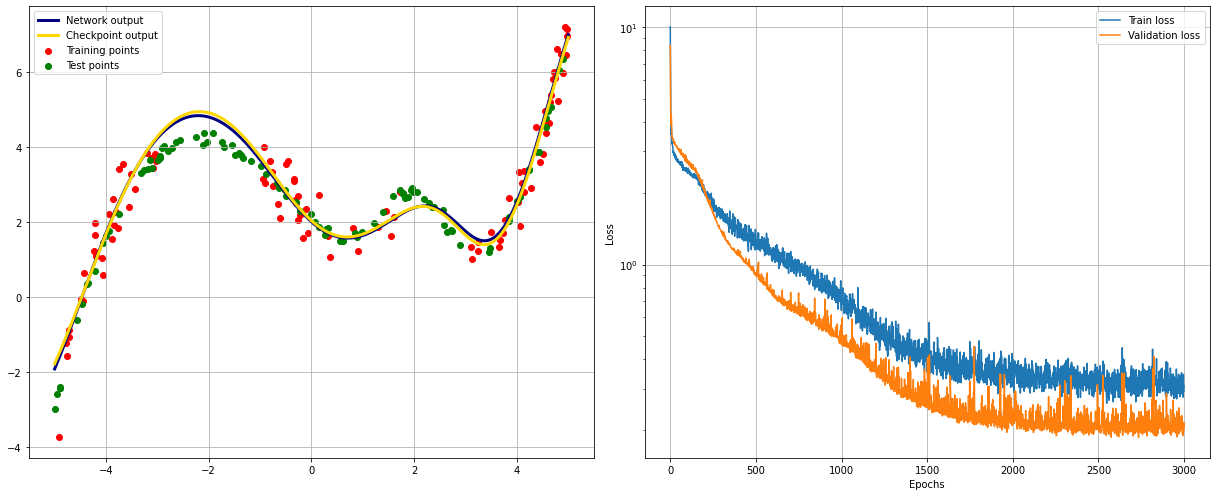

In [40]:
np.random.seed(0)
torch.manual_seed(10)

train_loss_regr, val_loss_regr, reg_net_rand = regr_training(n_epochs=3000,  
                                                        num_units=best_params['n_units'], 
                                                        depth=best_params["depth"], 
                                                        dropout=best_params["dropout"],
                                                        nonlin=best_params["activation"],
                                                        weights_init=best_params["weights_init"],
                                                        mod_loss=regr_loss, 
                                                        mod_opt_name="Adam", 
                                                        lr=best_params["lr"],
                                                        w_d=best_params["w_d"])

standard_plots(reg_net_rand, 'best_version_provv.h5' ,train_loss_regr, val_loss_regr)

In [41]:
print("Loss on the test set: %.4f" %(val_loop(reg_net_rand.to(device), test_dataloader_regr,nn.MSELoss())))

Loss on the test set: 0.1635


# CLASSIFICATION TASK

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

Some sequences of transformation are defined in advance in order to be inserted during the dataset definition. Both for the training and test datasets we transforms the samples into tensors and translate them from the range [0,1] (in which the values are rational numbers) to [0,255] (in which they become integers). This last procedure results in better performances for the future training of the net.
Two different composition of transformations are defined for the training dataset. In the `composed\transform\clean`, there are only the transformation used for the test set, while in the `composed\transform` also some image transformation, as the Vertical flip and the Rotation, which allow the net to become more robust during the classification task. 
For the first part of the classification work the "clean" dataset will be used, then, after showing some interesting results, the dataset with the image transformation will be adopted in order to make the task more complete.

In [42]:
composed_transform_clean = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Lambda(lambda x: x*255),
                                         ])

composed_transform = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Lambda(lambda x: x*255),
                                         transforms.RandomVerticalFlip(p=0.3),
                                         transforms.RandomRotation((-45,45))
                                         ])

test_composed_transform = transforms.Compose([transforms.ToTensor(), 
                                                transforms.Lambda(lambda x: x*255)
                                                ])

For this task I preferred to use the command yet implemented in torchvison library to download the FashionMNIST dataset. By default (with no transformation) the dataset is composed by item made by a PIL image object and a number corresponding to the target. In order to adapt it to the task, with the parameters transform and target transform, the PIL images are converted to float tensors with dimensions (1,28,28) (1 corresponds to the color channel) and the targets in long tensors of 1 element.

In [43]:
train_mnist = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, 
                                                transform=composed_transform, 
                                                )
train_mnist_clean = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, 
                                                transform=composed_transform_clean, 
                                                )
test_mnist  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True,
                                                transform=test_composed_transform, 
                                                )

The training dataset is now splitted into 2 subsets, one larger as training set and one smaller as validation. In order to do this it's possible to use the random split command from torch library.

In [44]:
train_dim=int(len(train_mnist)*0.9)
val_dim=int(len(train_mnist)-train_dim)

train_dataset_clean, val_dataset_clean = random_split(train_mnist_clean, [train_dim, val_dim])
train_dataset, val_dataset = random_split(train_mnist, [train_dim, val_dim])

print("Training dataset dimenison: ", len(train_dataset))
print("Validation dataset dimenison: ", len(val_dataset))

print("Test dataset dimenison: ", len(test_mnist))

Training dataset dimenison:  54000
Validation dataset dimenison:  6000
Test dataset dimenison:  10000


How to get an image and the corresponding label:

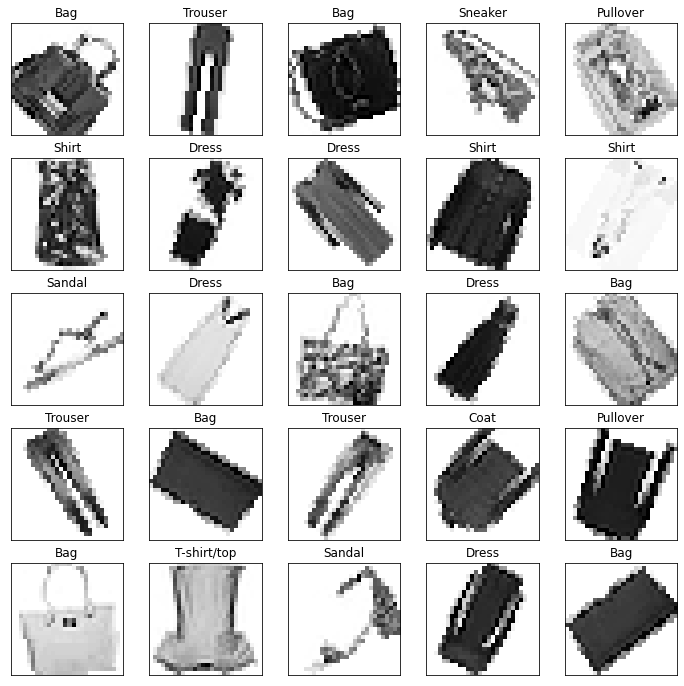

In [45]:
poss_labels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

sample_index = np.random.randint(0,1000,25)
__, ax = plt.subplots(5,5,figsize=(12,12))

for i,axi in enumerate(ax.flatten()):
    image = train_dataset[sample_index[i]][0][0]
    axi.imshow(image, cmap="Greys")
    axi.set_title(poss_labels[train_dataset[sample_index[i]][1]])
    axi.set_xticks([])
    axi.set_yticks([])

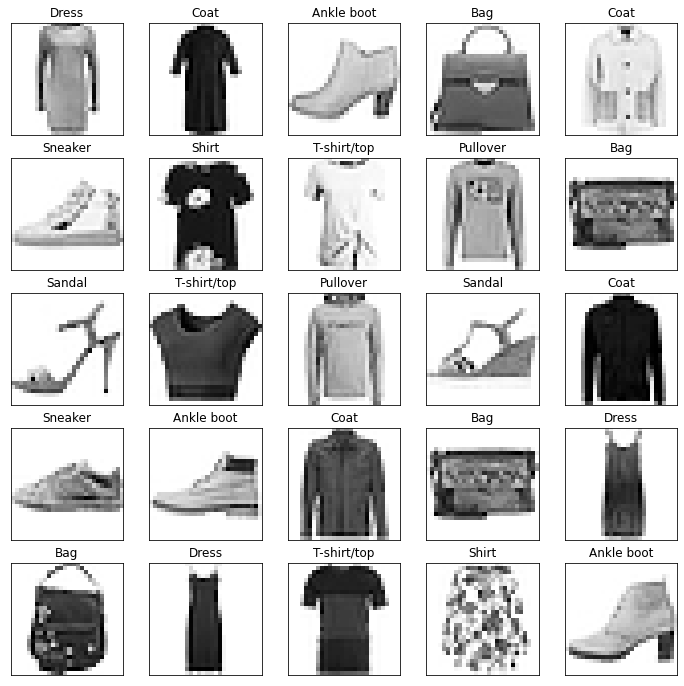

In [46]:
poss_labels=["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

sample_index = np.random.randint(0,1000,25)
__, ax = plt.subplots(5,5,figsize=(12,12))

for i,axi in enumerate(ax.flatten()):
    image = train_dataset_clean[sample_index[i]][0][0]
    axi.imshow(image, cmap="Greys")
    axi.set_title(poss_labels[train_dataset_clean[sample_index[i]][1]])
    axi.set_xticks([])
    axi.set_yticks([])

In the following cell, the dataloaders are defined. The batch size dimension are chosen to be quite small in order to not occupy all the GPU's memory.

In [47]:
np.random.seed(0)
torch.manual_seed(10)

nw=0
train_dataloader_clean = DataLoader(train_dataset_clean, batch_size=150, shuffle=True, num_workers=nw)
val_dataloader_clean = DataLoader(val_dataset_clean, batch_size=150, shuffle=False, num_workers=nw)
test_dataloader = DataLoader(test_mnist, batch_size=5, shuffle=False, num_workers=nw)

## Functions for manual training and result presentation

Function that implements the training of the model passes as a parameter. It is composed by a train and validation loop over the epochs.

In [48]:
def ClassificationTraining(model, nepochs, criterion, optimizer_name, lr, w_d, train_dataloader, val_dataloader, printt=False):
    train_loss_log=[]
    #train_acc_log=[]
    val_loss_log = []



    if optimizer_name=="Adam" or optimizer_name=="adam":
        optimizer_conv=optim.Adam(params=model.parameters(), lr=lr, weight_decay=w_d)
    else:
        optimizer_conv=optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)

    for epoch in tqdm(range(nepochs)):  # loop over the dataset multiple times
        train_loss= []
        #train_acc=[]
        model.train()
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs=data[0].to(device)
            labels=data[1].to(device)

            # zero the parameter gradients
            optimizer_conv.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_conv.step()

            # print statistics
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            #train_acc.append(myacc(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy()))
        # Save average train loss
        train_loss = np.mean(train_loss)
        if printt: print(f"AVERAGE TRAIN LOSS: {train_loss}")

        train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss= []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):
                # get the inputs; data is a list of [inputs, labels]
                inputs=data[0].to(device)
                #print(inputs.shape)
                labels=data[1].to(device)

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                #total += 1

                # print statistics
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

            # Save average train loss
            val_loss = np.mean(val_loss)
            if printt: print(f"AVERAGE VALIDATION LOSS: {val_loss}")
            val_loss_log.append(val_loss)

    #print('Finished Training')

    return model, train_loss_log, val_loss_log

Function that plots the loss (both training and validation) trend, and the confusion matrix, normalized over the predicted labels, between predicted and true labels.

In [49]:
def plotresults(model, train_loss, val_loss, ):
    ffig,(axloss, axheat) = plt.subplots(ncols=2, nrows=1, figsize=(14,7))
    axloss.plot(train_loss, label="Train loss")
    axloss.plot(val_loss, label="Validation loss")
    axloss.set_xlabel("Epochs")
    axloss.set_ylabel("Loss")
    plt.tight_layout()
    axloss.grid()
    axloss.legend()

    model.eval()
    with torch.no_grad():
        pred_val = model(test_mnist.data.unsqueeze(1).float().to(device)).argmax(axis=1).cpu().numpy()

    labels = test_mnist.targets.numpy()

    sns.heatmap(confusion_matrix(labels, pred_val, normalize="true"), ax=axheat, annot=True, cbar=False )
    axheat.set_xticklabels(poss_labels, rotation=45)
    axheat.set_yticklabels(poss_labels, rotation=45)
    axheat.set_xlabel("Predicted", fontsize=12)
    axheat.set_ylabel("True", fontsize=12)
    axheat.set_title("Confusion Matrix", fontsize=15, fontweight="bold")

    ffig.tight_layout()
    plt.show()

    print(f"Prediction accuracy: {np.sum(labels==pred_val)/len(labels)}")



def plotresults_skorch(net):
    ffig,(axloss, axheat) = plt.subplots(ncols=2, nrows=1, figsize=(14,7))
    axloss.plot(net.history[:,'train_loss'], label="Train loss")
    axloss.plot(net.history[:,'valid_loss'], label="Validation loss")
    axloss.set_xlabel("Epochs")
    axloss.set_ylabel("Loss")
    axloss.grid()
    axloss.legend()

    pred_val=net.predict(test_mnist.data.unsqueeze(1).float())

    sns.heatmap(confusion_matrix(test_mnist.targets, pred_val, normalize="true"), ax=axheat, annot=True, cbar=False )
    axheat.set_xticklabels(poss_labels, rotation=45)
    axheat.set_yticklabels(poss_labels, rotation=45)
    axheat.set_xlabel("Predicted", fontsize=12)
    axheat.set_ylabel("True", fontsize=12)
    axheat.set_title("Confusion Matrix", fontsize=15, fontweight="bold")

    plt.tight_layout()

    print(f"Prediction accuracy: {np.sum(np.equal(test_mnist.targets,pred_val).float().numpy())/len(test_mnist)}")


Function to plot the weights of a given layer.

In [50]:
def plotweights(model_layer, ncols, nrows, d1,d2, title=""):
    _,ax_w=plt.subplots(ncols=ncols, nrows=nrows, figsize=(int(1.5*ncols),int(1.5*nrows)))
    ax_w=ax_w.flatten()
    for i in range(nrows*ncols):
        ax_w[i].imshow(model_layer.weight.detach().cpu()[i].reshape((d1,d2)), cmap="gray")
        ax_w[i].set_xticklabels("")
        ax_w[i].set_yticklabels("")
        ax_w[i].set_xticks([])
        ax_w[i].set_yticks([])
    
    _.suptitle(title, fontsize=15, fontweight="bold")
    plt.tight_layout()

    plt.show()

## Network

### LINEAR

As first case I studied a classifier composed only by Linear layers, activations and Dropouts. The depth and general shape of the net is kept fixed, and the only parameter of the module is the dropout probability.

In [51]:
class LinNet(nn.Module):
    
    def __init__(self,p=0, activation=nn.ReLU()):
        """
        N - vector with layer dimensions
        """
        super().__init__()
        
        self.flat= nn.Flatten(1)
        self.fc1 = nn.Linear(in_features=28*28, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.drop= nn.Dropout(p=p)
        self.out = nn.Linear(in_features=50 , out_features=10)
        self.act = activation
        self.finact = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.flat(x)
        x = self.act(self.fc1(x))
        x = self.drop(x)
        x = self.act(self.fc2(x))
        x = self.act(self.out(x))
        return x

In [ ]:
currNNlin=LinNet(p=0.16)
currNNlin.to(device)
summary(currNNlin, (1,28,28))

Network initialized
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
           Dropout-4                  [-1, 100]               0
            Linear-5                   [-1, 50]           5,050
              ReLU-6                   [-1, 50]               0
            Linear-7                   [-1, 10]             510
              ReLU-8                   [-1, 10]               0
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


#### Manual Training

In [ ]:
np.random.seed(0)
torch.manual_seed(10)

criterion_lin = nn.CrossEntropyLoss()

currNNlin, train_loss_linear, val_loss_linear = ClassificationTraining(currNNlin, 
                                                                       nepochs = 50, 
                                                                       criterion = criterion_lin, 
                                                                       optimizer_name = "adam", 
                                                                       lr=5e-4, 
                                                                       #printt=True,
                                                                       w_d=1e-4,
                                                                       train_dataloader=train_dataloader_clean,
                                                                       val_dataloader=val_dataloader_clean
                                                                       )

100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


If desidered, this command allows to save the network weights in order to load the in a just initialized network to start the training form a more advanced state.

In [ ]:
#torch.save(currNNlin.state_dict(),"LINEAR.h5")  #unmute if you want to save the network weights

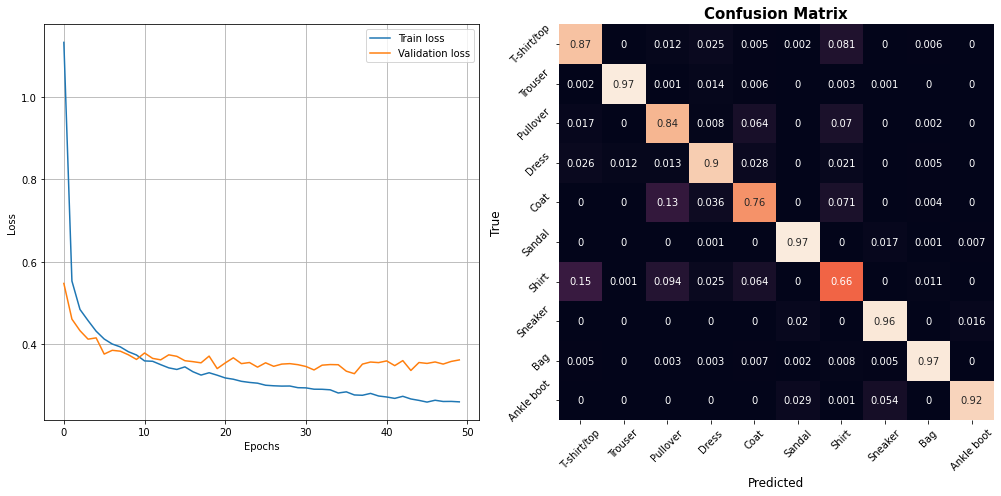

Prediction accuracy: 0.8811


In [ ]:
plotresults(currNNlin, train_loss_linear, val_loss_linear)

As we can see, even with a very simple model, the calssification performance is pretty good.

#### Weights

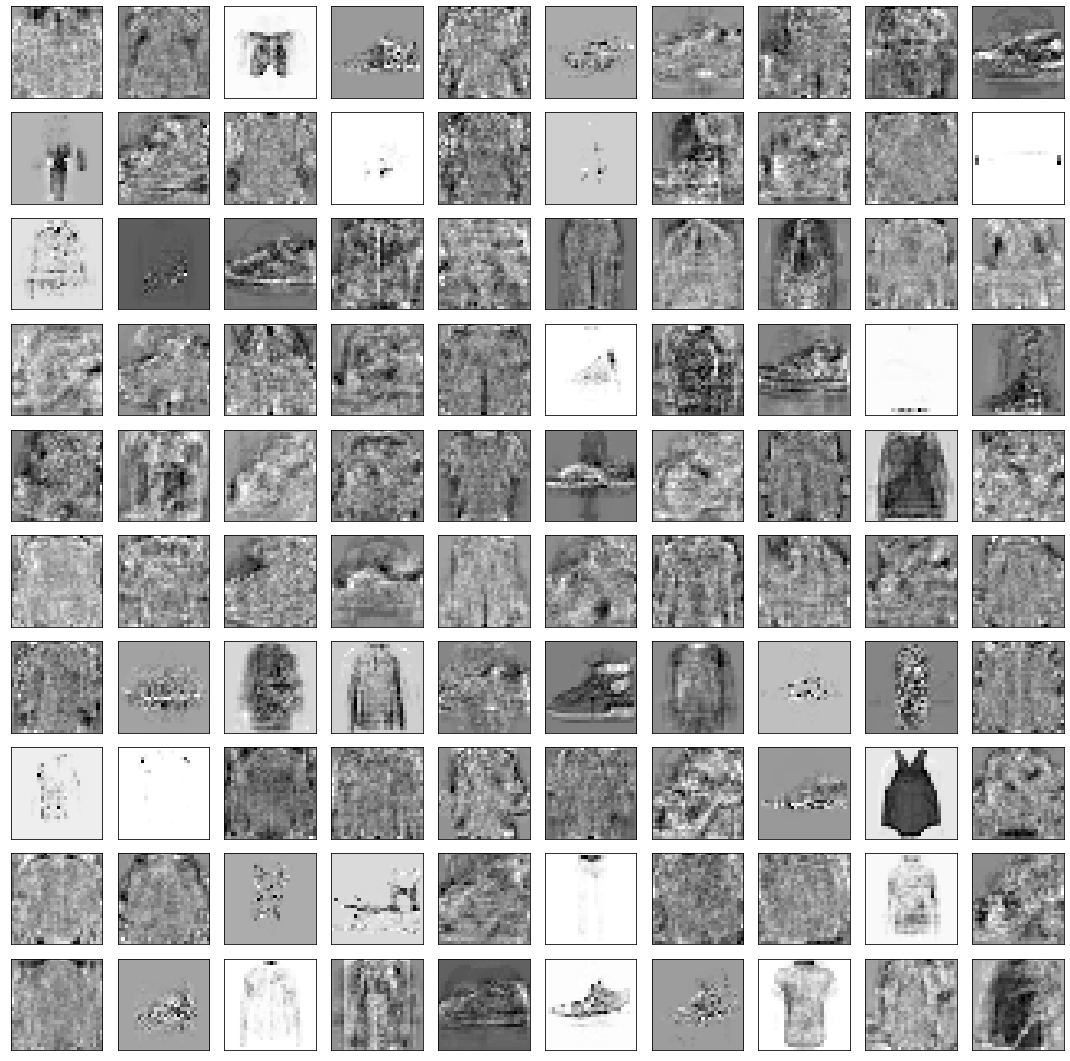

In [ ]:
plotweights(currNNlin.fc1,10,10,28,28)

Some images representing the weight values for specific neurons in the first layer, display the shape, although quite noisy, of some kind of cloth, meaning that probably that specific unit is specialized in recongnizing that specific kinf of sample. And also there are more than one unit which display similar shapes, and this means that there is some kind of redundancy in the net, which makes it more robust.

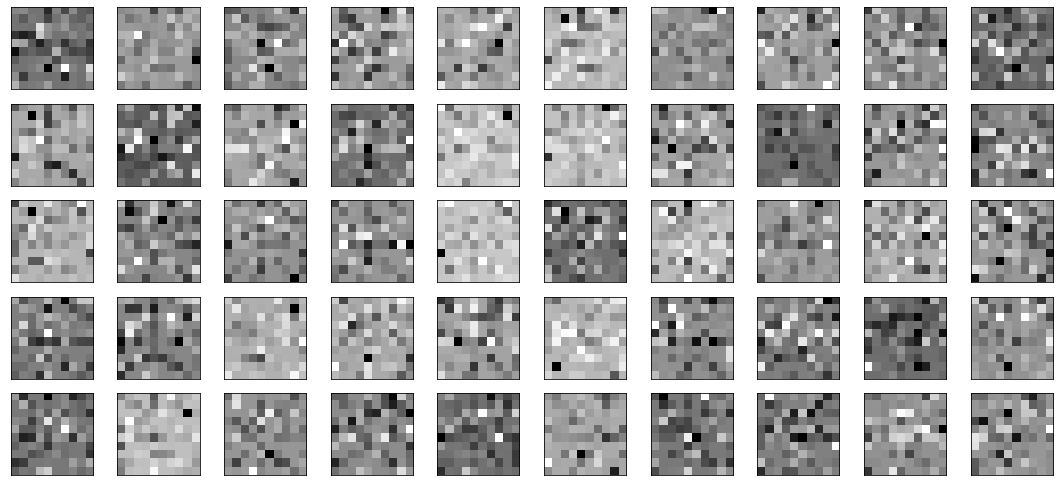

In [ ]:
plotweights(currNNlin.fc2, 10,5,10,10)

#### Activations

In [ ]:
def get_activation_classifier(layer, input, output):
    global activation_classifier
    activation_classifier = nn.ReLU()(output)
    return activation_classifier

def ConvActivations(hook, ind, show=True):
    ### Register hook  
    indicies = np.where(test_mnist.targets==ind)[0]
    hook_handle = hook

    ### Analyze activations
    #reg_net.to(device)
    currNNlin.eval()
    with torch.no_grad():
        x1 = test_mnist[indicies[0]][0].unsqueeze(0).to(device)
        y1 = currNNlin(x1)
        z1 = activation_classifier
        x2 = test_mnist[indicies[1]][0].unsqueeze(0).to(device)
        y2 = currNNlin(x2)
        z2 = activation_classifier
        x3 = test_mnist[indicies[2]][0].unsqueeze(0).to(device)
        y3 = currNNlin(x3)
        z3 = activation_classifier

    ### Remove hook
    hook_handle.remove()
    if show:
        ### Plot activations
        fig, axs = plt.subplots(3, 1, figsize=(12,6))
        axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
        axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
        axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
        fig.suptitle(f'First layer activations for input {poss_labels[test_mnist[indicies[2]][1]]}', fontweight="bold", fontsize=15)
        plt.tight_layout()
        plt.show()
    return [z1,z2,z3]

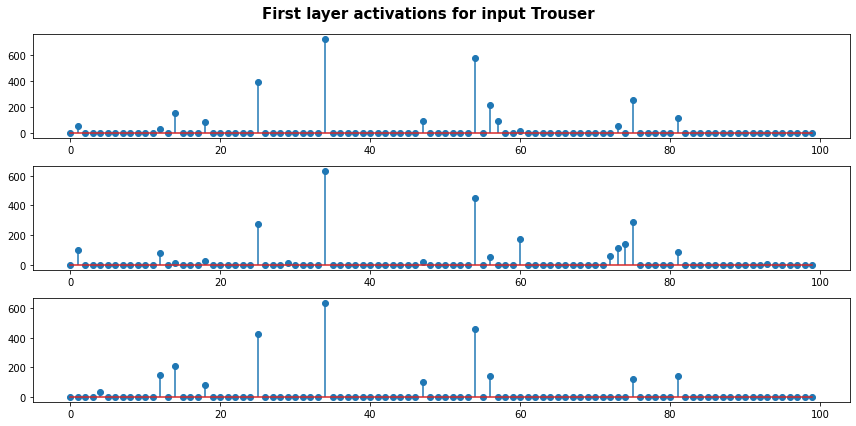

In [ ]:
__ = ConvActivations(currNNlin.fc1.register_forward_hook(get_activation_classifier), 1)

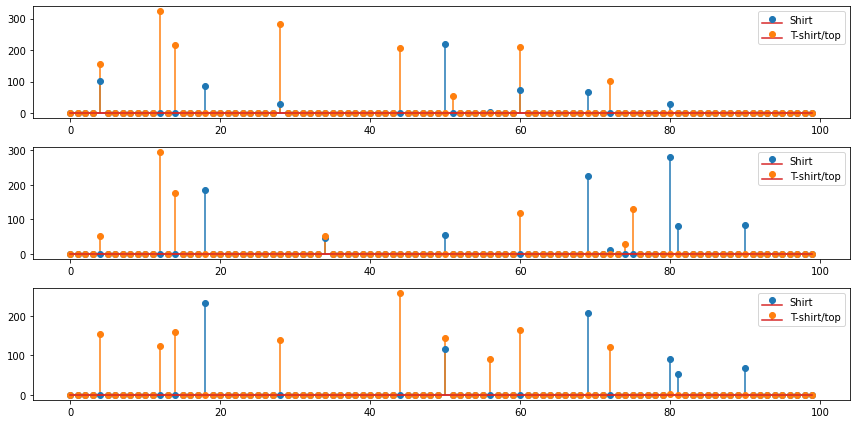

In [ ]:
comparison_clothes = [6,0]

shirt_act = ConvActivations(currNNlin.fc1.register_forward_hook(get_activation_classifier), 
                            ind = comparison_clothes[0], 
                            show=False)
top_act = ConvActivations(currNNlin.fc1.register_forward_hook(get_activation_classifier), 
                            ind = comparison_clothes[1], 
                            show=False)

fig, axs = plt.subplots(3, 1, figsize=(12,6))
for i, z_list in enumerate([shirt_act, top_act]):
    axs[0].stem(z_list[0].cpu().numpy()[0], use_line_collection=True, markerfmt=f"C{i}o", linefmt=f"C{i}-", label=poss_labels[comparison_clothes[i]])
    axs[1].stem(z_list[1].cpu().numpy()[0], use_line_collection=True, markerfmt=f"C{i}o", linefmt=f"C{i}-", label=poss_labels[comparison_clothes[i]])
    axs[2].stem(z_list[2].cpu().numpy()[0], use_line_collection=True, markerfmt=f"C{i}o", linefmt=f"C{i}-", label=poss_labels[comparison_clothes[i]])
[aix.legend() for aix in axs]
plt.tight_layout()
plt.show()


In most of the cases it is possible to see that input beloging to the same class produce similar activation patterns in the first layer. And also similar objects sometimes show similar patterns, as in the case of T-shirt/top vs Shirt.

#### Using Dataset with image transformations

Now the network is trained with the dataset in which randomVertical and RandomRotation transformation are applied. The dataloaders are redifined and all the main commands for training and results showing of the network are called.

In [ ]:
np.random.seed(0)
torch.manual_seed(10)

nw=0
train_dataloader = DataLoader(train_dataset, batch_size=150, shuffle=True, num_workers=nw)
val_dataloader = DataLoader(val_dataset, batch_size=150, shuffle=False, num_workers=nw)
test_dataloader = DataLoader(test_mnist, batch_size=5, shuffle=False, num_workers=nw)

In [ ]:
currNNlin=LinNet(p=0.16)
currNNlin.to(device)
summary(currNNlin, (1,28,28))

Network initialized
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
           Dropout-4                  [-1, 100]               0
            Linear-5                   [-1, 50]           5,050
              ReLU-6                   [-1, 50]               0
            Linear-7                   [-1, 10]             510
              ReLU-8                   [-1, 10]               0
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [ ]:
np.random.seed(0)
torch.manual_seed(10)

criterion_lin = nn.CrossEntropyLoss()

currNNlin, train_loss_linear, val_loss_linear = ClassificationTraining(currNNlin, 
                                                                       nepochs = 50, 
                                                                       criterion = criterion_lin, 
                                                                       optimizer_name = "adam", 
                                                                       lr=5e-4, 
                                                                       #printt=True,
                                                                       w_d=1e-4,
                                                                       train_dataloader=train_dataloader,
                                                                       val_dataloader=val_dataloader
                                                                       )

100%|██████████| 50/50 [11:46<00:00, 14.13s/it]


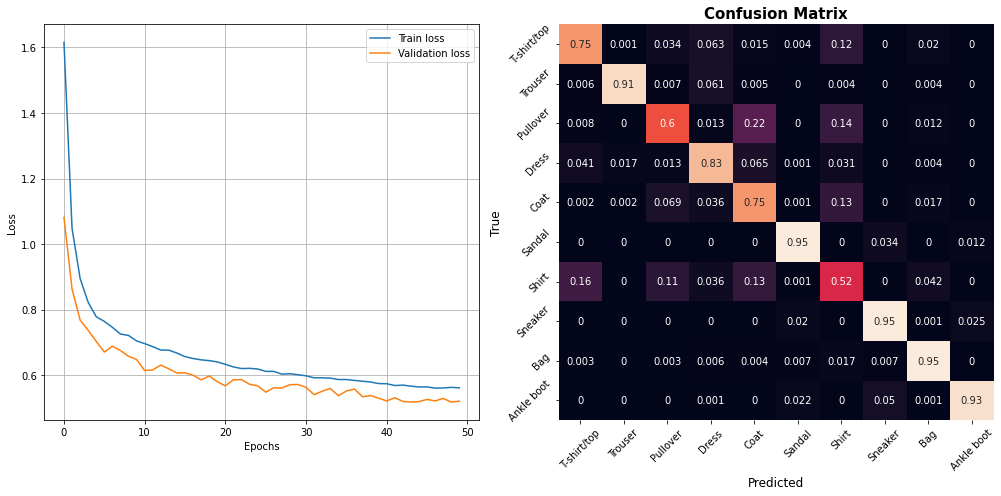

Prediction accuracy: 0.8144


In [ ]:
plotresults(currNNlin, train_loss_linear, val_loss_linear)

As it is possible to see, the performances are less good than in the case in which the structure of the images wasn't changed. In fact, the network cannot anymore create patterns similar to the original images and compare them with the original sample because the rotation and flipping of them makes this procedure useless. So the network has to identify local and simpler patterns, similarly to the way a convolutional layer operates. This reasoning can be verified by looking at the weights in the images below.

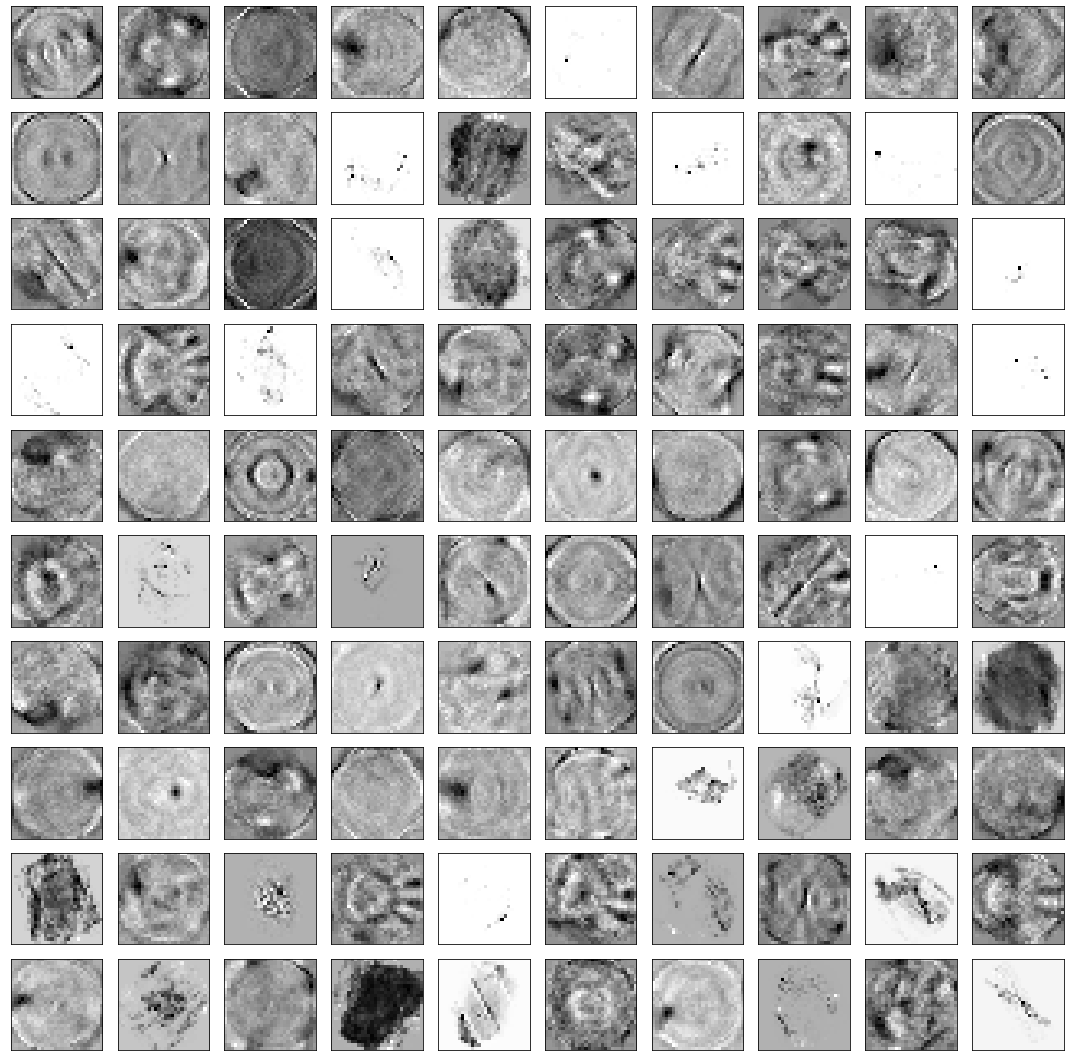

In [ ]:
plotweights(currNNlin.fc1,10,10,28,28)

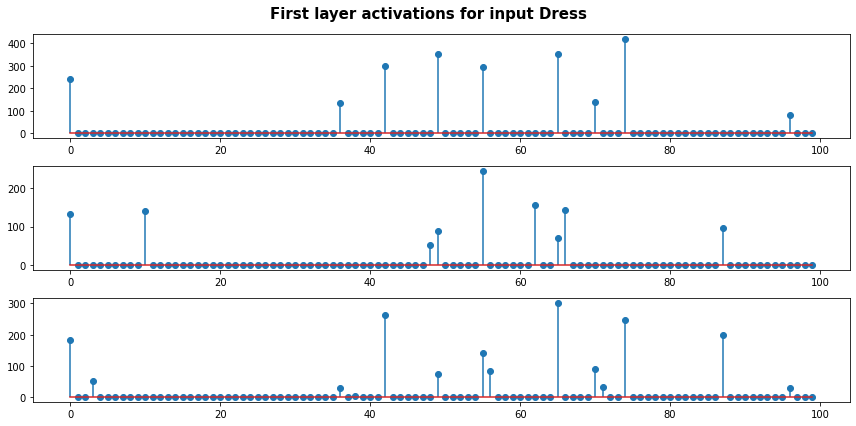

In [ ]:
__ = ConvActivations(currNNlin.fc1.register_forward_hook(get_activation_classifier), 3)

#### CrossValidation

Customized function to implement a cross validation procedure in order to use the "Manual triaining" function.

In [ ]:
def CrossVal(ncv):
    kf=KFold(ncv, shuffle=True)
    val_kf=[]
    for train_index, test_index in kf.split(train_mnist):

        train_subsamp = SubsetRandomSampler(train_index)
        test_subsamp = SubsetRandomSampler(test_index)
        trainloader_kf = DataLoader(
                        train_mnist, 
                        batch_size=128, sampler=train_subsamp,pin_memory=True)
        testloader_kf = DataLoader(
                        train_mnist,
                        batch_size=128, sampler=test_subsamp, pin_memory=True)
        
        currNNlin=LinNet(p=0.16)
        currNNlin.to(device)
        
        ___, __tl, val_loss_kf = ClassificationTraining(currNNlin, 
                                                        nepochs = 10, 
                                                        criterion = criterion_lin, 
                                                        optimizer_name = "adam", 
                                                        lr=5e-4, 
                                                        #printt=True,
                                                        w_d=1e-4,
                                                        train_dataloader=trainloader_kf,
                                                        val_dataloader=testloader_kf
                                                        )
        val_kf.append(val_loss_kf[-1])
                                  
    return np.mean(val_kf)


In [ ]:
CrossVal(3)

Network initialized


100%|██████████| 10/10 [03:07<00:00, 18.76s/it]


Network initialized


100%|██████████| 10/10 [03:08<00:00, 18.89s/it]


Network initialized


100%|██████████| 10/10 [03:08<00:00, 18.84s/it]


1.3156625

#### Training with TrochBearer

The `TorchBearer` library is another useful tool which allows to implement the training of the network in a compact and intuitive way. The dataset has to be rearranged in order to encounter the requirements of the library, and this is done thanks to the `get_train - val_dataset` function of `torchbearer.cv_utils`. The batch size is chosen in order to have a good speed in the computation and at the same time keeping it small enough to avoid GPU memory filling.

In [ ]:
splitter = DatasetValidationSplitter(len(train_mnist), 0.2)

trainset = splitter.get_train_dataset(train_mnist)
valset = splitter.get_val_dataset(train_mnist)

traingen = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
valgen = DataLoader(valset, batch_size=128, shuffle=True, num_workers=0)
testgen = DataLoader(test_mnist, batch_size=128, shuffle=False, num_workers=0)

In addition to the other methods, here I used both the loss and the accuracy as metrics for the model, so it is possibile to see directly how much the network is able to perform correct classificaiton with the epochs.

In [ ]:
trial = Trial(currNNlin, 
              optim.Adam(currNNlin.parameters(), lr=4.5e-05, weight_decay=2e-4), 
              nn.CrossEntropyLoss(), 
              metrics=["loss", "acc"]).cuda()

trial.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)

mytrial = trial.run(epochs=50, verbose=1)

  0%|          | 0/50 [00:00<?, ?it/s]

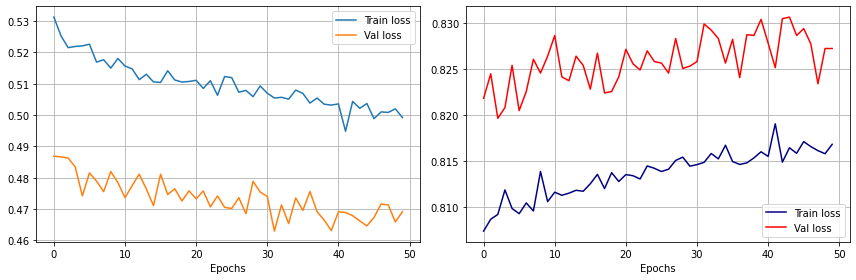

In [ ]:
__, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot([mt["loss"] for mt in mytrial], label="Train loss")
ax[0].plot([mt["val_loss"] for mt in mytrial], label="Val loss")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train loss", color="navy")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val loss", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid() for axi in ax]

plt.tight_layout()

#### Training with SKORCH

Training the model with Skorch in the classification task results in a great increase of the computational speed. That's because the sklearn wrapper only allows to get as input torch Tensors, and not dataloaders. This is possible in this case because the dataset is not too large and can fit in the RAM memory, but for larger dataset this wouldn't be recommended.
But, after realizing the advantages and disadvantages of this methods, skorch training results much faster than the manual one in our case, and for this reason in use in the hyperparameters selection sections.

In order to work with Skorch, it must be created a tensor with all the images of the transformed trianing set.

In [52]:
dtss=torch.Tensor([train_mnist[i][0].numpy() for i in range(len(train_mnist.targets))])

In [ ]:

net_lin = NeuralNetClassifier(
    LinNet,
    module__p=0.17,
    module__activation=nn.ReLU(),
    max_epochs=50,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=4.5e-05,
    optimizer__weight_decay=2e-4,
    batch_size=150,
    device='cuda',
    #verbose=0
)

In [ ]:
net_lin.fit(dtss, train_mnist.targets)

Network initialized
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.0003       0.1662        2.2132  0.6955
      2        2.1416       0.3406        1.9105  0.6987
      3        1.8575       0.4761        1.6096  0.6685
      4        1.6090       0.5309        1.4090  0.6698
      5        1.4514       0.5539        1.2963  0.6682
      6        1.3413       0.6090        1.2035  0.6645
      7        1.2487       0.6379        1.1412  0.6688
      8        1.1877       0.6531        1.0918  0.6669
      9        1.1364       0.6632        1.0511  0.7026
     10        1.0899       0.6769        1.0086  0.7412
     11        1.0493       0.6816        0.9824  0.7425
     12        1.0179       0.6918        0.9636  0.7428
     13        0.9915       0.6959        0.9466  0.7410
     14        0.9648       0.6977        0.9352  0.7479
     15        0.9466       0.7014        0.9274  0.7439
     16    

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LinNet(
    (flat): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=784, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (drop): Dropout(p=0.17, inplace=False)
    (out): Linear(in_features=50, out_features=10, bias=True)
    (act): ReLU()
    (finact): Softmax(dim=1)
  ),
)

Prediction accuracy: 0.7873


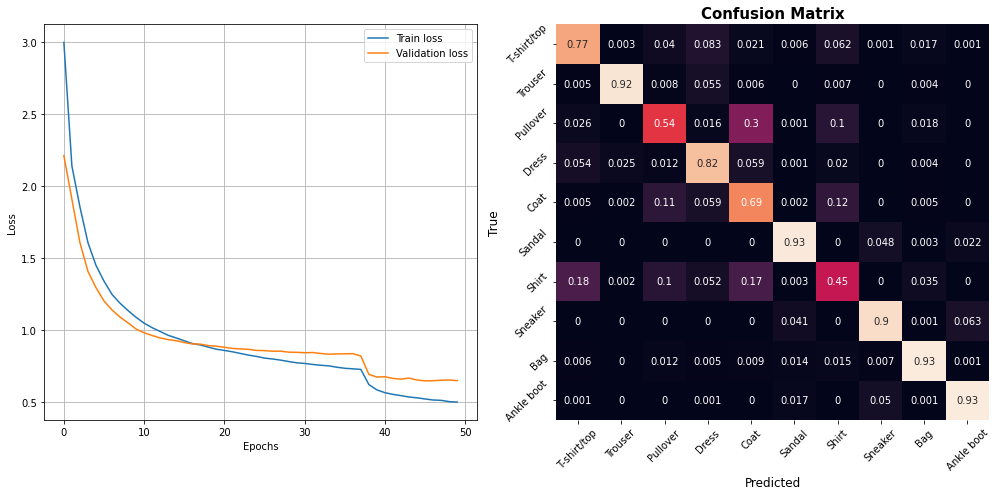

In [ ]:
plotresults_skorch(net_lin)

Skorch also allows to use the `cross_val_score` of sklearn on our pytorch model. It computes the accuracy of the validation set by applying the KFold cross validation procedure, i.e. splitting the dataset in *cv* folds and use *cv-1* of them to perform the training, and the last one to evaluate the score as a validation dataset. Then all the permutations are performed and at the end the final score given by the function is the mean of the accuracy for each of the *cv* iterations.

In [ ]:
cross_val_score(net_lin,train_mnist.data.unsqueeze(1).float(), train_mnist.targets, cv=5)

Network initialized
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4231       0.3544        1.7901  0.6262
      2        1.7899       0.4167        1.6606  0.6055
      3        1.6667       0.4406        1.5914  0.5643
      4        1.6072       0.4634        1.5491  0.5631
      5        1.4746       0.5325        1.3135  0.5703
      6        1.2976       0.5764        1.1826  0.5948
      7        1.1857       0.6248        1.0194  0.5918
      8        0.9372       0.7244        0.7795  0.5957
      9        0.7987       0.7358        0.7320  0.5936
     10        0.7552       0.7418        0.7080  0.5948
     11        0.7271       0.7459        0.6892  0.5922
     12        0.7001       0.7528        0.6720  0.5944
     13        0.5471       0.8424        0.4549  0.5966
     14        0.4619       0.8481        0.4389  0.5932
     15        0.4426       0.8459        0.4323  0.5956
     16    

array([0.88158333, 0.78491667, 0.87683333, 0.88133333, 0.878     ])

#### Hyperparameters Optimization with OPTUNA

For the reasons explained before, in this optimization part section, Skorch and `cross_val_score` are used, in order to have a fast and robust training and evaluation of the network for each trial of hyperparameters combinations.

Depending on which training set we decide to use in the objective function, is possible to search for the best hyperparameters for the case of a training dataset with no transformations of the images, or the one with these transformations. The results in this two cases can be very different.

In [86]:
np.random.seed(0)
torch.manual_seed(10)

def objective(trial):

    # We optimize the number of hidden units in each layer.
    hyperparameters = [
        trial.suggest_float("droput", 0, 0.3),
        trial.suggest_categorical("activation", ["relu", "sigmoid", "tanh"]),
        trial.suggest_float("lr", 1e-6, 1e-4, log=True),
        trial.suggest_float("w_d", 1e-6, 1e-3, log=True),
        trial.suggest_categorical("optimizer", ["SGD","Adam"])
    ]

    if hyperparameters[1]=="Sigmoid" or hyperparameters[1]=="sigmoid":
        activ=nn.Sigmoid()
    elif hyperparameters[1]=="ReLU" or hyperparameters[1]=="relu":
        activ=nn.ReLU()
    elif hyperparameters[1]=="Tanh" or hyperparameters[1]=="tanh":
        activ=nn.Tanh()

    if hyperparameters[4]=="SGD" or hyperparameters[4]=="sgd":
        optimiz=optim.SGD
    elif hyperparameters[4]=="Adam" or hyperparameters[4]=="adam":
        optimiz=optim.Adam

    net_opt = NeuralNetClassifier(
                            LinNet,
                            max_epochs=30,
                            module__p=hyperparameters[0],
                            module__activation=activ,
                            criterion=nn.CrossEntropyLoss,
                            optimizer=optimiz,
                            lr=hyperparameters[2],
                            optimizer__weight_decay=hyperparameters[3],
                            batch_size=150,
                            device='cuda',  # uncomment this to train with CUDA
                            verbose=0
                        )
    cross_va_res=cross_val_score(net_opt,dtss, train_mnist.targets, cv=5)
    print(cross_va_res)
    return cross_va_res.mean() 
    #return cross_val_score(net_opt,train_mnist.data.unsqueeze(1).float(), train_mnist.targets, cv=5).mean() 

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler=TPESampler(seed=100)
study = optuna.create_study(study_name="LinNetOptunaHyperparameters", direction="maximize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=30, timeout=10000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Validation loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-11 15:38:18,917] A new study created in memory with name: LinNetOptunaHyperparameters
[I 2022-01-11 15:40:25,184] Trial 0 finished with value: 0.3990333333333333 and parameters: {'droput': 0.16302148253728962, 'activation': 'tanh', 'lr': 1.0219689767013376e-06, 'w_d': 2.315833661913894e-06, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3990333333333333.


[0.4085     0.41458333 0.39475    0.37691667 0.40041667]


[I 2022-01-11 15:42:28,324] Trial 1 finished with value: 0.31475 and parameters: {'droput': 0.04101197690548589, 'activation': 'sigmoid', 'lr': 2.347774812542223e-06, 'w_d': 2.114125046324831e-06, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.3990333333333333.


[0.36933333 0.33208333 0.32758333 0.29341667 0.25133333]


[I 2022-01-11 15:44:15,057] Trial 2 finished with value: 0.10274999999999998 and parameters: {'droput': 0.24350494472679696, 'activation': 'sigmoid', 'lr': 7.30143742110752e-06, 'w_d': 0.0006608295560579288, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.3990333333333333.


[0.10316667 0.11008333 0.10025    0.1        0.10025   ]


[I 2022-01-11 15:46:15,263] Trial 3 finished with value: 0.7038166666666666 and parameters: {'droput': 0.052623136122700996, 'activation': 'relu', 'lr': 3.902339203642011e-05, 'w_d': 1.1111301029398567e-06, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7038166666666666.


[0.58075    0.71416667 0.7085     0.76491667 0.75075   ]


[I 2022-01-11 15:48:04,279] Trial 4 finished with value: 0.43788333333333335 and parameters: {'droput': 0.031544305623616896, 'activation': 'tanh', 'lr': 9.158866189014106e-05, 'w_d': 1.5129548450137261e-06, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.7038166666666666.


[0.42458333 0.43358333 0.43183333 0.454      0.44541667]


[I 2022-01-11 15:49:52,886] Trial 5 finished with value: 0.11895 and parameters: {'droput': 0.2227439067293932, 'activation': 'relu', 'lr': 2.63058994247684e-06, 'w_d': 4.305807744337717e-05, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.7038166666666666.


[0.10366667 0.11491667 0.13958333 0.10641667 0.13016667]


[I 2022-01-11 15:51:41,249] Trial 6 finished with value: 0.10388333333333336 and parameters: {'droput': 0.0857687071220594, 'activation': 'sigmoid', 'lr': 5.23619350770195e-06, 'w_d': 6.260036099225523e-05, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.7038166666666666.


[0.11925    0.1        0.1        0.10016667 0.1       ]


[I 2022-01-11 15:53:30,213] Trial 7 finished with value: 0.16386666666666666 and parameters: {'droput': 0.05342429685174146, 'activation': 'tanh', 'lr': 5.655941496566086e-06, 'w_d': 6.003661571473681e-05, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.7038166666666666.


[0.16833333 0.14216667 0.14791667 0.16425    0.19666667]


[I 2022-01-11 15:55:21,310] Trial 8 finished with value: 0.13261666666666666 and parameters: {'droput': 0.2801523898399257, 'activation': 'relu', 'lr': 5.3256915325583555e-06, 'w_d': 4.102379474596645e-06, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.7038166666666666.


[0.13033333 0.12391667 0.18958333 0.11266667 0.10658333]


[I 2022-01-11 15:57:26,939] Trial 9 finished with value: 0.5838000000000001 and parameters: {'droput': 0.05208240052206152, 'activation': 'relu', 'lr': 2.9013592439301706e-05, 'w_d': 1.049918694066394e-05, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7038166666666666.


[0.4445     0.63141667 0.741      0.59466667 0.50741667]


[I 2022-01-11 15:59:30,007] Trial 10 finished with value: 0.6671666666666666 and parameters: {'droput': 0.1159377193452403, 'activation': 'relu', 'lr': 2.6170430062398872e-05, 'w_d': 0.0003912358188529501, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7038166666666666.


[0.65675    0.60941667 0.697      0.64158333 0.73108333]


[I 2022-01-11 16:01:35,524] Trial 11 finished with value: 0.6698000000000001 and parameters: {'droput': 0.12545702467234557, 'activation': 'relu', 'lr': 2.6572656372080598e-05, 'w_d': 0.00048773043481721904, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7038166666666666.


[0.67716667 0.72216667 0.69483333 0.52625    0.72858333]


[I 2022-01-11 16:03:39,542] Trial 12 finished with value: 0.6758666666666666 and parameters: {'droput': 0.15448895192624365, 'activation': 'relu', 'lr': 2.7993172121978292e-05, 'w_d': 0.00017975632110903874, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7038166666666666.


[0.74158333 0.72675    0.69883333 0.52358333 0.68858333]


[I 2022-01-11 16:05:45,666] Trial 13 finished with value: 0.7425333333333333 and parameters: {'droput': 0.17483892404551332, 'activation': 'relu', 'lr': 5.731765114837886e-05, 'w_d': 0.00014158042700210542, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.7425333333333333.


[0.75833333 0.74683333 0.75975    0.77058333 0.67716667]


[I 2022-01-11 16:07:44,849] Trial 14 finished with value: 0.7364666666666666 and parameters: {'droput': 0.19560540902344337, 'activation': 'relu', 'lr': 9.764261481988681e-05, 'w_d': 1.5329604376969297e-05, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.7425333333333333.


[0.67175    0.74416667 0.7635     0.74808333 0.75483333]


[I 2022-01-11 16:09:47,008] Trial 15 finished with value: 0.7544000000000001 and parameters: {'droput': 0.20429320807575577, 'activation': 'relu', 'lr': 9.335039688710434e-05, 'w_d': 1.4677289262281507e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.7685     0.75466667 0.76833333 0.7705     0.71      ]


[I 2022-01-11 16:11:52,451] Trial 16 finished with value: 0.7214333333333334 and parameters: {'droput': 0.19487730765119138, 'activation': 'relu', 'lr': 5.70120514915413e-05, 'w_d': 0.0001325719194779441, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.75958333 0.76425    0.76225    0.6        0.72108333]


[I 2022-01-11 16:13:55,507] Trial 17 finished with value: 0.5787166666666667 and parameters: {'droput': 0.2834446929307285, 'activation': 'relu', 'lr': 1.2455538281937122e-05, 'w_d': 1.732747817280783e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.61733333 0.26033333 0.64891667 0.68316667 0.68383333]


[I 2022-01-11 16:15:58,746] Trial 18 finished with value: 0.5740000000000001 and parameters: {'droput': 0.24322099851419682, 'activation': 'tanh', 'lr': 1.4415092400945114e-05, 'w_d': 7.4324671071892574e-06, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.5615     0.53575    0.59016667 0.58475    0.59783333]


[I 2022-01-11 16:18:02,497] Trial 19 finished with value: 0.39754999999999996 and parameters: {'droput': 0.18579594304656366, 'activation': 'sigmoid', 'lr': 5.88970230601945e-05, 'w_d': 0.0001256459121033757, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.40658333 0.37133333 0.3945     0.4015     0.41383333]


[I 2022-01-11 16:20:06,510] Trial 20 finished with value: 0.6895333333333333 and parameters: {'droput': 0.12010424961742709, 'activation': 'relu', 'lr': 6.294192843717989e-05, 'w_d': 3.090638280265044e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.67075    0.61558333 0.61941667 0.77575    0.76616667]


[I 2022-01-11 16:22:09,368] Trial 21 finished with value: 0.7252000000000001 and parameters: {'droput': 0.1922985996652713, 'activation': 'relu', 'lr': 9.30245591754363e-05, 'w_d': 2.3617937574529073e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.76875    0.7685     0.62133333 0.69441667 0.773     ]


[I 2022-01-11 16:24:15,141] Trial 22 finished with value: 0.7234166666666667 and parameters: {'droput': 0.21882178036417985, 'activation': 'relu', 'lr': 9.144570412265507e-05, 'w_d': 1.0607821286195317e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.76875    0.7595     0.68525    0.639      0.76458333]


[I 2022-01-11 16:26:19,764] Trial 23 finished with value: 0.6573166666666668 and parameters: {'droput': 0.17428402919044697, 'activation': 'relu', 'lr': 4.7043903526614e-05, 'w_d': 5.607777117123494e-06, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.71891667 0.718      0.61483333 0.66808333 0.56675   ]


[I 2022-01-11 16:28:18,374] Trial 24 finished with value: 0.7458166666666666 and parameters: {'droput': 0.21291374842835648, 'activation': 'relu', 'lr': 9.921922271526965e-05, 'w_d': 1.597853568464066e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.76675    0.74708333 0.77433333 0.6765     0.76441667]


[I 2022-01-11 16:30:30,630] Trial 25 finished with value: 0.6151833333333333 and parameters: {'droput': 0.2531402793253621, 'activation': 'relu', 'lr': 1.8314679588359502e-05, 'w_d': 0.00022176755450576945, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.34083333 0.69908333 0.703      0.71008333 0.62291667]


[I 2022-01-11 16:32:35,145] Trial 26 finished with value: 0.7176166666666667 and parameters: {'droput': 0.21618243951922766, 'activation': 'relu', 'lr': 4.48092030874347e-05, 'w_d': 5.777065063238733e-05, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.71858333 0.74325    0.71958333 0.65975    0.74691667]


[I 2022-01-11 16:34:31,764] Trial 27 finished with value: 0.65045 and parameters: {'droput': 0.14026618920748837, 'activation': 'tanh', 'lr': 7.346720470673848e-05, 'w_d': 0.00010240412790404078, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.60641667 0.67966667 0.67516667 0.61158333 0.67941667]


[I 2022-01-11 16:36:22,336] Trial 28 finished with value: 0.36888333333333334 and parameters: {'droput': 0.2625397233495451, 'activation': 'sigmoid', 'lr': 3.722592166049309e-05, 'w_d': 3.5201409779509527e-06, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.7544000000000001.


[0.37575    0.34358333 0.37       0.36991667 0.38516667]


[I 2022-01-11 16:38:12,593] Trial 29 finished with value: 0.7629833333333333 and parameters: {'droput': 0.16813172798078838, 'activation': 'relu', 'lr': 6.837480749673843e-05, 'w_d': 0.0009744258858917638, 'optimizer': 'Adam'}. Best is trial 29 with value: 0.7629833333333333.


[0.76433333 0.763      0.75016667 0.77575    0.76166667]
Number of finished trials: 30
Best trial:
  Validation loss: 0.7629833333333333
  Params: 
    droput: 0.16813172798078838
    activation: relu
    lr: 6.837480749673843e-05
    w_d: 0.0009744258858917638
    optimizer: Adam


From the results of the optimization it's possible to see that the `relu` activation, with suitable values of learning rate and weight decay, leads to better results. Another important factor is the optimizer: `Adam` works better in almost all the cases, but it's difficult to state its superiority in the task, because `SGD` could work as well but in different ranges of the learning rate, which are hard to explore.

In [93]:
hyp_opt_lin=list(trial.params.values())

net_opt = NeuralNetClassifier(
                            LinNet,
                            max_epochs=50,
                            module__p=hyp_opt_lin[0],
                            module__activation=nn.ReLU(),
                            criterion=nn.CrossEntropyLoss,
                            optimizer=optim.Adam,
                            lr=hyp_opt_lin[2],
                            optimizer__weight_decay=hyp_opt_lin[3],
                            batch_size=150,
                            device='cuda',  # uncomment this to train with CUDA
                            verbose=1
                        )
net_opt.fit(dtss, train_mnist.targets)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.6614       0.3047        2.0125  1.1370
      2        1.8552       0.5102        1.4897  1.1979
      3        1.4741       0.6008        1.2418  1.2518
      4        1.2146       0.6680        0.9846  1.0766
      5        1.0278       0.6881        0.8902  1.4369
      6        0.9466       0.6987        0.8460  1.1153
      7        0.8929       0.7096        0.8119  1.4124
      8        0.8558       0.7201        0.7840  0.9784
      9        0.8197       0.7272        0.7620  0.9857
     10        0.7879       0.7284        0.7495  0.9912
     11        0.7693       0.7352        0.7371  1.0313
     12        0.7488       0.7392        0.7249  1.2114
     13        0.7282       0.7424        0.7136  1.3375
     14        0.7084       0.7502        0.7005  1.1825
     15        0.6900       0.7493        0.7003  1.2558
     16        0.6771       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LinNet(
    (flat): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=784, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
    (drop): Dropout(p=0.16813172798078838, inplace=False)
    (out): Linear(in_features=50, out_features=10, bias=True)
    (act): ReLU()
    (finact): Softmax(dim=1)
  ),
)

Prediction accuracy: 0.7921


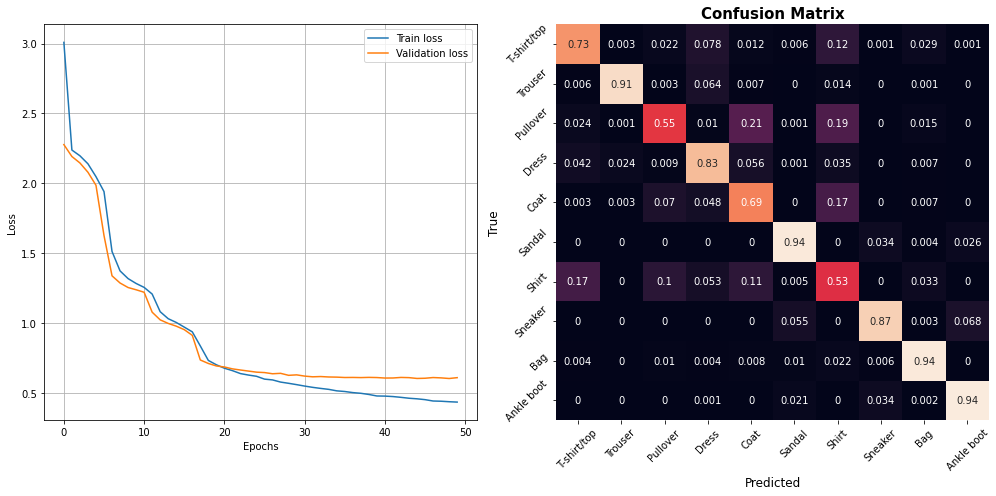

In [92]:
plotresults_skorch(net_opt)

### CONVOLUTIONAL

In the following cells I tried to explore the performances of a Classifier composed also by convolutional layer, which in principle are very useful tools when dealing with images, as in our case. Another type of layers added in the module, is the `BatchNorm2D`, which perform a normalization over the weights of the network with the goal to speed up the training, perform some kind of regularization and avoid gradient problems as exploding or vanishing gradient.


In [62]:
class ClassCoNet(nn.Module):
    def __init__(self, dropout=0, nonlin=nn.ReLU()):
        super(ClassCoNet, self).__init__()
        self.dropout=dropout

        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=25, kernel_size=(4,4),stride=2,bias=True),
            nonlin,
            nn.BatchNorm2d(num_features=25),
            nn.Conv2d(in_channels=25, out_channels=9, kernel_size=(3,3),stride=2,bias=True),
            nonlin,
            nn.BatchNorm2d(num_features=9),
            nn.Flatten(),
            nn.Linear(in_features=108*3, out_features=100),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=100 , out_features=10),
            nonlin
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
currNNconv=ClassCoNet(dropout=0.15)

currNNconv.to(device)
summary(currNNconv, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 13, 13]             425
              ReLU-2           [-1, 25, 13, 13]               0
       BatchNorm2d-3           [-1, 25, 13, 13]              50
            Conv2d-4              [-1, 9, 6, 6]           2,034
              ReLU-5              [-1, 9, 6, 6]               0
       BatchNorm2d-6              [-1, 9, 6, 6]              18
           Flatten-7                  [-1, 324]               0
            Linear-8                  [-1, 100]          32,500
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
             ReLU-11                   [-1, 10]               0
Total params: 36,037
Trainable params: 36,037
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

#### Manual trianing and Results; Clean dataset

In [81]:
currNNconv_clean=ClassCoNet(dropout=0.15)

currNNconv_clean.to(device)

np.random.seed(0)
torch.manual_seed(10)

criterion_conv = nn.CrossEntropyLoss()

currNNconv_clean, train_loss_conv_clean, val_loss_conv_clean = ClassificationTraining(model = currNNconv_clean,
                                                                    nepochs = 50,
                                                                    criterion = criterion_conv,
                                                                    optimizer_name = "Adam",
                                                                    lr=5e-4,
                                                                    w_d=1e-5,
                                                                    printt=False,
                                                                    train_dataloader=train_dataloader_clean,
                                                                    val_dataloader=val_dataloader_clean)

100%|██████████| 50/50 [04:56<00:00,  5.93s/it]


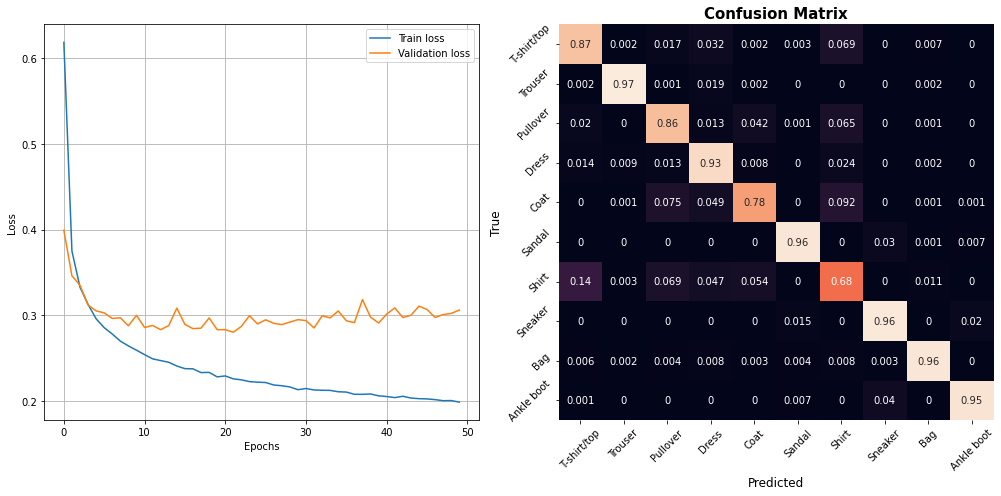

Prediction accuracy: 0.8929


In [82]:
plotresults(currNNconv_clean, train_loss_conv_clean, val_loss_conv_clean)

#### Manual trianing and Results; Transformed dataset

In [ ]:
np.random.seed(0)
torch.manual_seed(10)

criterion_conv = nn.CrossEntropyLoss()

currNNconv, train_loss_conv, val_loss_conv = ClassificationTraining(model = currNNconv,
                                                                    nepochs = 50,
                                                                    criterion = criterion_conv,
                                                                    optimizer_name = "Adam",
                                                                    lr=5e-4,
                                                                    w_d=1e-5,
                                                                    printt=False,
                                                                    train_dataloader=train_dataloader,
                                                                    val_dataloader=val_dataloader)

100%|██████████| 50/50 [11:58<00:00, 14.37s/it]


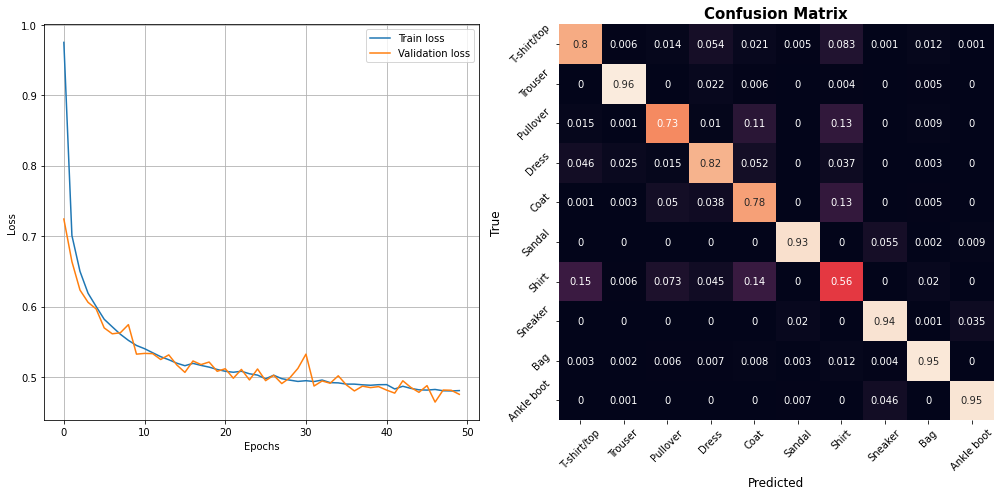

Prediction accuracy: 0.8433


In [ ]:
plotresults(currNNconv, train_loss_conv, val_loss_conv)

#### Weights

The weight plots of a convolutional layer are at first sight less interesting than the one of a linear layer, because their purpose is just to recognize local patterns of the image, which can be shades, angles, edges, and for the small kernel dimension used for the small dimension images of the dataset, it's even hard to recognize such patterns.

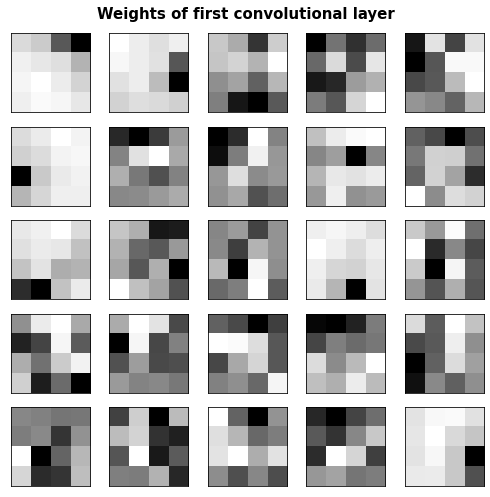

In [ ]:
plotweights(currNNconv.main[0],5,5,4,4, "Weights of first convolutional layer")

#### Activations

Much more interesting is to look at the activation of a convolutional layer. In this case we consider the first layer of the network, and the result is a series of images, each of a smaller dimension than the original one, due to the padding and the kernel dimension, which shows how the image is fileterd by each of the pattern recognitions that compose the convolutional layer.

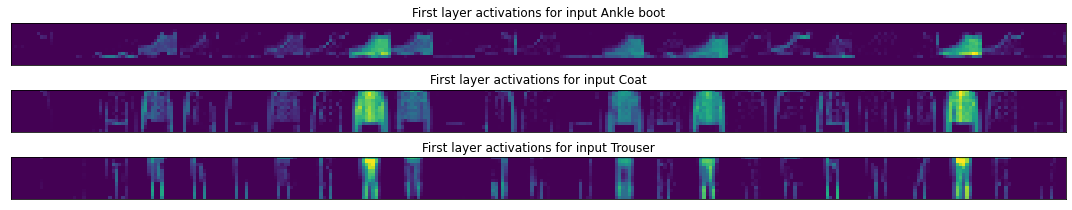

In [ ]:
### Register hook  
hook_handle = currNNconv.main[0].register_forward_hook(get_activation_classifier)

### Analyze activations
#reg_net.to(device)
currNNconv.eval()
with torch.no_grad():
    x1 = test_mnist[0][0].unsqueeze(0).to(device)
    y1 = currNNconv(x1)
    z1 = activation_classifier

    x2 = test_mnist[10][0].unsqueeze(0).to(device)
    y2 = currNNconv(x2)
    z2 = activation_classifier

    x3 = test_mnist[3][0].unsqueeze(0).to(device)
    y3 = currNNconv(x3)
    z3 = activation_classifier


### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(15,3))

axs[0].imshow(np.hstack(z1.detach().cpu().numpy()[0]))
axs[0].set_title(f'First layer activations for input {poss_labels[test_mnist[0][1]]}')
axs[1].imshow(np.hstack(z2.detach().cpu().numpy()[0]))
axs[1].set_title(f'First layer activations for input {poss_labels[test_mnist[10][1]]}')
axs[2].imshow(np.hstack(z3.detach().cpu().numpy()[0]))
axs[2].set_title(f'First layer activations for input {poss_labels[test_mnist[3][1]]}')
[ax.set_xticks([]) for ax in axs ]
[ax.set_yticks([]) for ax in axs ]
plt.tight_layout()
plt.show()

For the second convolutional layer we the activation images result less clear, but works in the same layer of the first case. The difference here is that they are not applied on the original image, but on the "level of activation" of each neuron of the previous layer with repect to the corresponding pattern represented by the kernel weights.

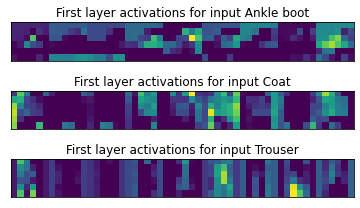

In [ ]:
### Register hook  
hook_handle = currNNconv.main[3].register_forward_hook(get_activation_classifier)

### Analyze activations
#reg_net.to(device)
currNNconv.eval()
with torch.no_grad():
    x1 = test_mnist[0][0].unsqueeze(0).to(device)
    y1 = currNNconv(x1)
    z1 = activation_classifier

    x2 = test_mnist[10][0].unsqueeze(0).to(device)
    y2 = currNNconv(x2)
    z2 = activation_classifier

    x3 = test_mnist[3][0].unsqueeze(0).to(device)
    y3 = currNNconv(x3)
    z3 = activation_classifier


### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(15,3))

axs[0].imshow(np.hstack(z1.detach().cpu().numpy()[0]))
axs[0].set_title(f'First layer activations for input {poss_labels[test_mnist[0][1]]}')
axs[1].imshow(np.hstack(z2.detach().cpu().numpy()[0]))
axs[1].set_title(f'First layer activations for input {poss_labels[test_mnist[10][1]]}')
axs[2].imshow(np.hstack(z3.detach().cpu().numpy()[0]))
axs[2].set_title(f'First layer activations for input {poss_labels[test_mnist[3][1]]}')
[ax.set_xticks([]) for ax in axs ]
[ax.set_yticks([]) for ax in axs ]
plt.tight_layout()
plt.show()

#### Training with SKORCH and Results

In [ ]:
net_conv = NeuralNetClassifier(
    ClassCoNet,
    module__dropout=0.1,
    max_epochs=50,
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    lr=1e-3,
    optimizer__weight_decay=1e-5,
    batch_size=150,
    device='cuda',  # uncomment this to train with CUDA
    #verbose=0
)

In [ ]:
net_conv.fit(dtss, train_mnist.targets)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8957       0.7483        0.6919  1.4033
      2        0.6514       0.7663        0.6339  1.3767
      3        0.6015       0.7790        0.6106  1.4272
      4        0.5722       0.7866        0.5906  1.4126
      5        0.5538       0.7916        0.5795  1.4219
      6        0.5409       0.7914        0.5764  1.4174
      7        0.5301       0.7942        0.5706  1.4164
      8        0.5210       0.7966        0.5661  1.4214
      9        0.5127       0.7957        0.5730  1.4573
     10        0.5079       0.7998        0.5653  1.3918
     11        0.5011       0.7998        0.5600  1.4170
     12        0.4961       0.7992        0.5589  1.4203
     13        0.4917       0.7968        0.5726  1.4220
     14        0.4892       0.8023        0.5563  1.4241
     15        0.4840       0.8043        0.5560  1.4208
     16        0.4809       0.8

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassCoNet(
    (main): Sequential(
      (0): Conv2d(1, 25, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(25, 9, kernel_size=(3, 3), stride=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=324, out_features=100, bias=True)
      (8): Dropout(p=0.1, inplace=False)
      (9): Linear(in_features=100, out_features=10, bias=True)
      (10): ReLU()
    )
  ),
)

Prediction accuracy: 0.8285


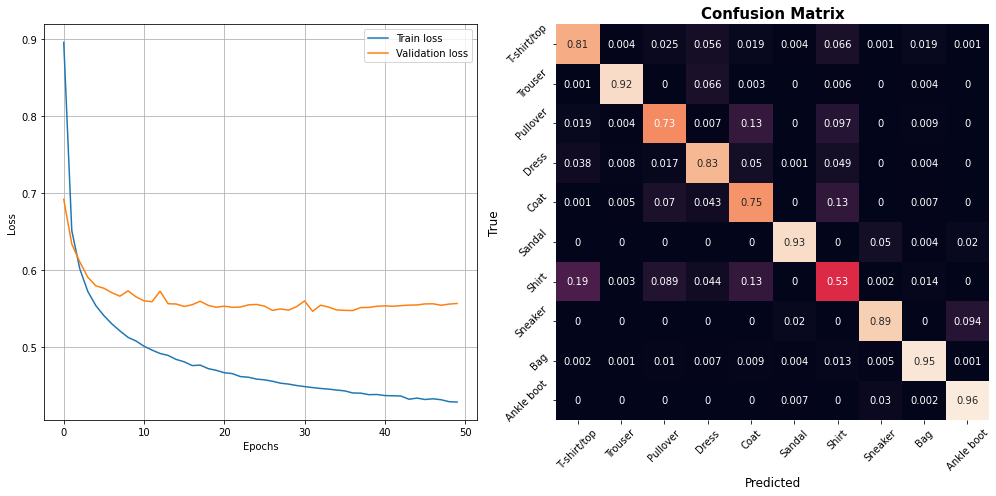

In [ ]:
plotresults_skorch(net_conv)

#### Optuna

In [66]:
np.random.seed(0)
torch.manual_seed(10)

def objective(trial):

    # We optimize the number of hidden units in each layer.
    hyperparameters = [
        trial.suggest_float("droput", 0, 0.3),
        trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"]),
        trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        trial.suggest_float("w_d", 1e-6, 1e-4, log=True),
        trial.suggest_categorical("optimizer", ["adam", "SGD"])
    ]

    if hyperparameters[1]=="Sigmoid" or hyperparameters[1]=="sigmoid":
        activ=nn.Sigmoid()
    elif hyperparameters[1]=="ReLU" or hyperparameters[1]=="relu":
        activ=nn.ReLU()
    elif hyperparameters[1]=="Tanh" or hyperparameters[1]=="tanh":
        activ=nn.Tanh()

    if hyperparameters[4]=="SGD" or hyperparameters[4]=="sgd":
        optimiz=optim.SGD
    elif hyperparameters[4]=="Adam" or hyperparameters[4]=="adam":
        optimiz=optim.Adam

    net_opt = NeuralNetClassifier(
                            ClassCoNet,
                            max_epochs=50,
                            module__dropout=hyperparameters[0],
                            module__nonlin= activ,
                            criterion=nn.CrossEntropyLoss,
                            optimizer=optimiz,
                            lr=hyperparameters[2],
                            optimizer__weight_decay=hyperparameters[3],
                            batch_size=150,
                            device='cuda',  # uncomment this to train with CUDA
                            verbose=0
                        )
    return cross_val_score(net_opt,dtss, train_mnist.targets, cv=5).mean() 
    #return cross_val_score(net_opt,train_mnist.data.unsqueeze(1).float(), train_mnist.targets, cv=5).mean() 

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler=TPESampler(seed=10)
study = optuna.create_study(study_name="ConvNetOptunaHyperparameters", direction="maximize", pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=30, timeout=15000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Validation loss: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-11 11:04:44,252] A new study created in memory with name: ConvNetOptunaHyperparameters
[I 2022-01-11 11:10:26,872] Trial 0 finished with value: 0.38789999999999997 and parameters: {'droput': 0.23139619298002378, 'activation': 'sigmoid', 'lr': 9.931481194831956e-05, 'w_d': 2.815744802026464e-06, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.38789999999999997.
[I 2022-01-11 11:16:30,045] Trial 1 finished with value: 0.6145666666666666 and parameters: {'droput': 0.050733250968760635, 'activation': 'sigmoid', 'lr': 1.0183487453386057e-05, 'w_d': 1.0577536357318941e-05, 'optimizer': 'adam'}. Best is trial 1 with value: 0.6145666666666666.
[I 2022-01-11 11:22:28,021] Trial 2 finished with value: 0.5152333333333333 and parameters: {'droput': 0.21652659522953985, 'activation': 'tanh', 'lr': 0.00012164345198856657, 'w_d': 1.9245982882901925e-06, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.6145666666666666.
[I 2022-01-11 11:28:46,772] Trial 3 finished with value: 0.7546833

Number of finished trials: 30
Best trial:
  Validation loss: 0.7960499999999999
  Params: 
    droput: 0.09447806155280648
    activation: relu
    lr: 0.0005752151938070465
    w_d: 3.361097991091426e-05
    optimizer: adam


From the result it's possible to see that the dropout contribution is important, and values around 0.1 usually lead to better performance with respect to the case in which the dropout probability is 0.
The best activation is the relu, a likely result for a convolutional network used for a classification task.

In [84]:
hyp_opt_conv = list(trial.params.values())


net_opt = NeuralNetClassifier(
                        ClassCoNet,
                        max_epochs=50,
                        module__dropout=0.09,
                        module__nonlin= nn.ReLU(),
                        criterion=nn.CrossEntropyLoss,
                        optimizer=optim.Adam,
                        lr=0.000575,
                        optimizer__weight_decay=0.0000336,
                        batch_size=150,
                        device='cuda',  # uncomment this to train with CUDA
                        verbose=1
                    )

net_opt.fit(dtss, train_mnist.targets)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0051       0.7284        0.7545  1.8112
      2        0.6970       0.7592        0.6647  1.7777
      3        0.6344       0.7693        0.6284  1.6867
      4        0.6008       0.7785        0.6082  1.7277
      5        0.5793       0.7827        0.5959  1.9159
      6        0.5616       0.7888        0.5829  1.9454
      7        0.5469       0.7904        0.5741  2.0365
      8        0.5351       0.7950        0.5681  2.0777
      9        0.5252       0.7956        0.5638  2.0224
     10        0.5189       0.7953        0.5602  2.0634
     11        0.5111       0.7971        0.5592  2.1009
     12        0.5042       0.7988        0.5576  1.9194
     13        0.4981       0.8001        0.5538  1.9809
     14        0.4940       0.8014        0.5535  1.9088
     15        0.4897       0.8020        0.5523  1.9467
     16        0.4861       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassCoNet(
    (main): Sequential(
      (0): Conv2d(1, 25, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(25, 9, kernel_size=(3, 3), stride=(2, 2))
      (4): ReLU()
      (5): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=324, out_features=100, bias=True)
      (8): Dropout(p=0.09, inplace=False)
      (9): Linear(in_features=100, out_features=10, bias=True)
      (10): ReLU()
    )
  ),
)

Prediction accuracy: 0.8205


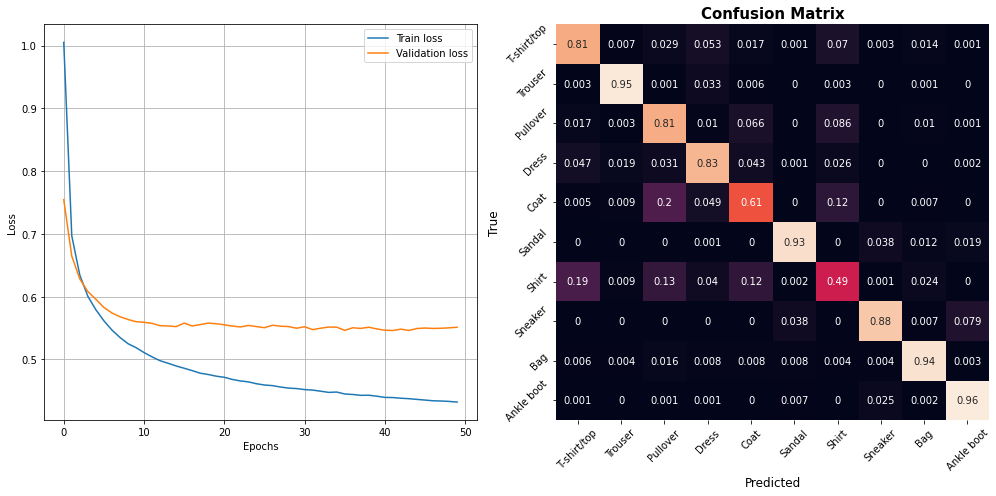

In [85]:
plotresults_skorch(net_opt)